# Lightweight U-net training and evaluation for Lung Ultrasound

This notebook describes the dataloading, training, and evaluation of u-net models for the semantic segmentation of a lung ultrasound (LUS) phantom

- Dataloading 
    - Pre-processing (crop, resize, one-hot encoding)
    - Augmentations to training data
    - Batch and shuffle
- Traning 
    - Loss functions including categorical cross-entropy and dice coefficient
    - LR reduction and early stopping
    - Validation and test plots
- Evaluation
    - Test metrics including IoU and Dice coefficient
    - Predictions on test set images
- Calculating the B-line artefact score (BLAS)

In [ ]:
# Generic imports
import sys
import numpy as np
import gc
from matplotlib import pyplot as plt # plotting
from matplotlib.patches import Rectangle
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Custom imports
from src import Preprocess as prep
from src import Postprocessing as post
from src import Metrics as metrics
from src import LossFunctions as loss
from src import Models as models
from src import Evaluate as eval
from src import Visualise as vis
from src import BLAS as blas
from src.DataLoader import DataLoader

LABEL_FONT_SIZE=12
AXIS_FONT_SIZE=12
TITLE_FONT_SIZE=16

%load_ext autoreload
%autoreload 2

print('-------------')
print(f'python version {sys.version}')
print(f'Tensorflow version {tf.__version__}')
print(f'cuda available: {tf.test.is_built_with_cuda()}')
print(f'Tensorflow GPU available: {tf.test.is_gpu_available()}')
print('-------------')


ModuleNotFoundError: No module named 'tensorflow'

: 

In [2]:
# Set up path variables
PATH_IMAGES_TRAIN = 'data/train/images/'
PATH_MASKS_TRAIN = 'data/train/masks/'

PATH_IMAGES_TEST = 'data/test/images/'
PATH_MASKS_TEST = 'data/test/masks/'

CLASSES = ['Ribs', 'Pleural line', 'A-line', 'B-line', 'B-line Confluence']
d_classes = {i+1:CLASSES[i] for i in range(len(CLASSES))}# map indices to classes
d_classes

{1: 'Ribs',
 2: 'Pleural line',
 3: 'A-line',
 4: 'B-line',
 5: 'B-line Confluence'}

## Data Loading
- List images and masks
- Split into traininig and validation sets
- Define pre-processing steps and augmentations
- Create dataloaders

Training images: 371
Training masks: 371
**************************************************
Validation images: 93
Validation masks: 93
**************************************************
Test images: 100
Test masks: 100
**************************************************


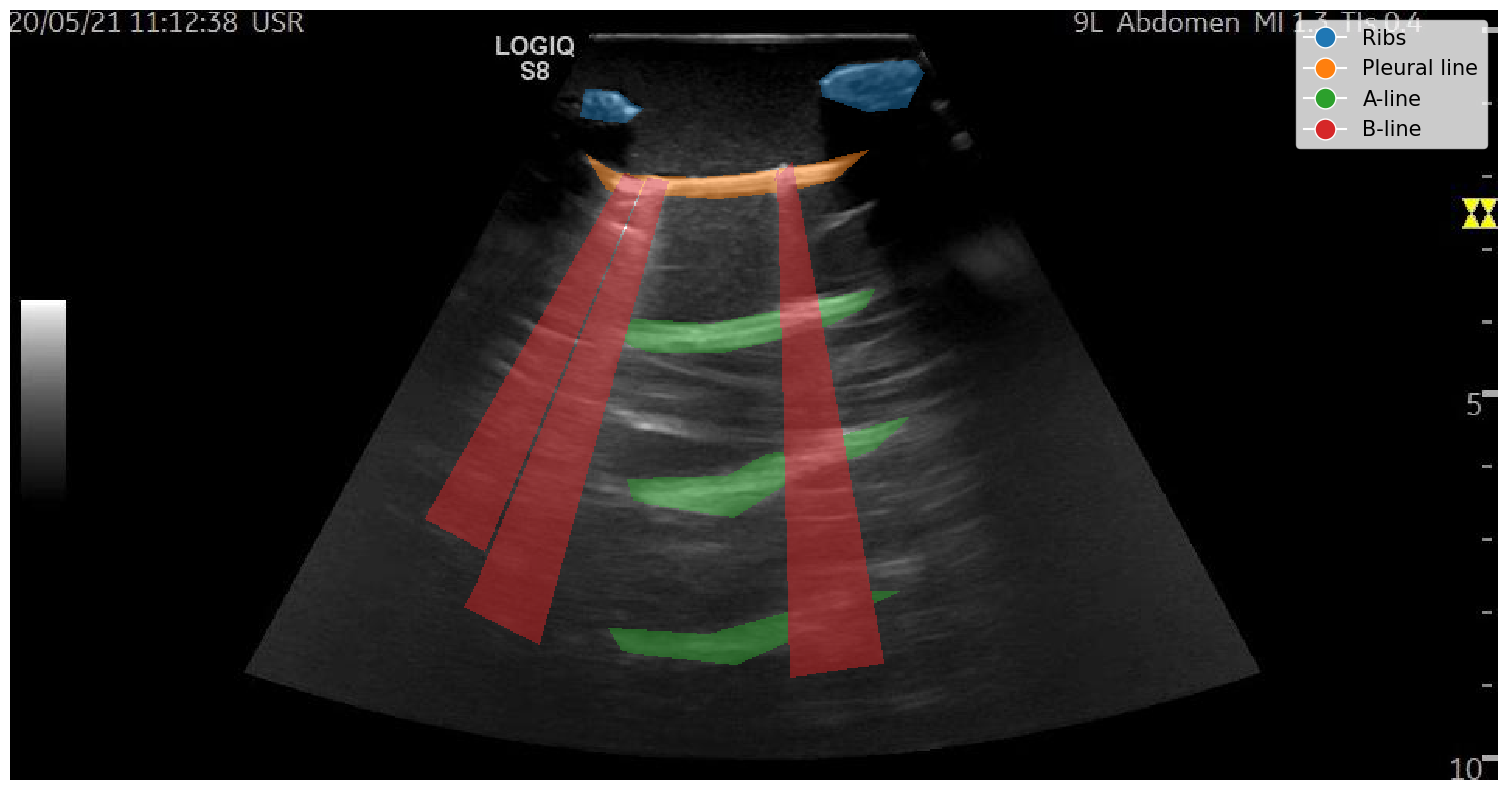

In [3]:
# List files is the training and test directories
image_paths_0 = prep.list_files(PATH_IMAGES_TRAIN, ext='.png')
mask_paths_0 = prep.list_files(PATH_MASKS_TRAIN, ext='.png')

test_im_paths = prep.list_files(PATH_IMAGES_TEST, ext='.png')
test_mask_paths = prep.list_files(PATH_MASKS_TEST, ext='.png')

# Split training and validation datasets
train_im_paths, valid_im_paths, train_mask_paths, valid_mask_paths = train_test_split(image_paths_0, mask_paths_0, test_size=0.2, shuffle=True) # split off test set
################################################################################################

print('Training images:' ,len(train_im_paths))
print('Training masks:', len(train_mask_paths))

print('*'*50)

print('Validation images:' ,len(valid_im_paths))
print('Validation masks:', len(valid_mask_paths))

print('*'*50)

print('Test images:' ,len(test_im_paths))
print('Test masks:', len(test_mask_paths))

print('*'*50)

# Show an example image from the training set
imno = 1
vis.display_image_mask(prep.read_image(test_im_paths[imno]), prep.read_mask(test_mask_paths[imno]), d_classes=d_classes, figsize=(20,10))

In [4]:
# Define parameters for dataloaders

# Metadata
shape = (256, 256, 1)
num_classes = 6
batch_size = 8


# Pre-processing transformations

d_transforms = {'crop':(100,50,850,460),    # (x1, y1, x2, y2) 
                'resize':shape[:2],         # (width, height) 
                'one-hot':True              # for mask
                                 }

# Image Augmentations to apply to training set

d_augs = {'hflip':True,                     # Horizontal flip (True/False)
          'rotate':30,                      # Rotation angle (float or None)
          'brightness':0.25,                # Brightness adjustment delta (float or None)
          'contrast':(0.75,1.25),           # Contrast adjustment range ( [float,float] or None)
          'depth':(0.75, 0.75),       # Crop and resize ( [float,float] or None),
          'tgc':True,                       # Time gain compensation (True or None)
          }


2024-01-30 17:27:43.390201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6018 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


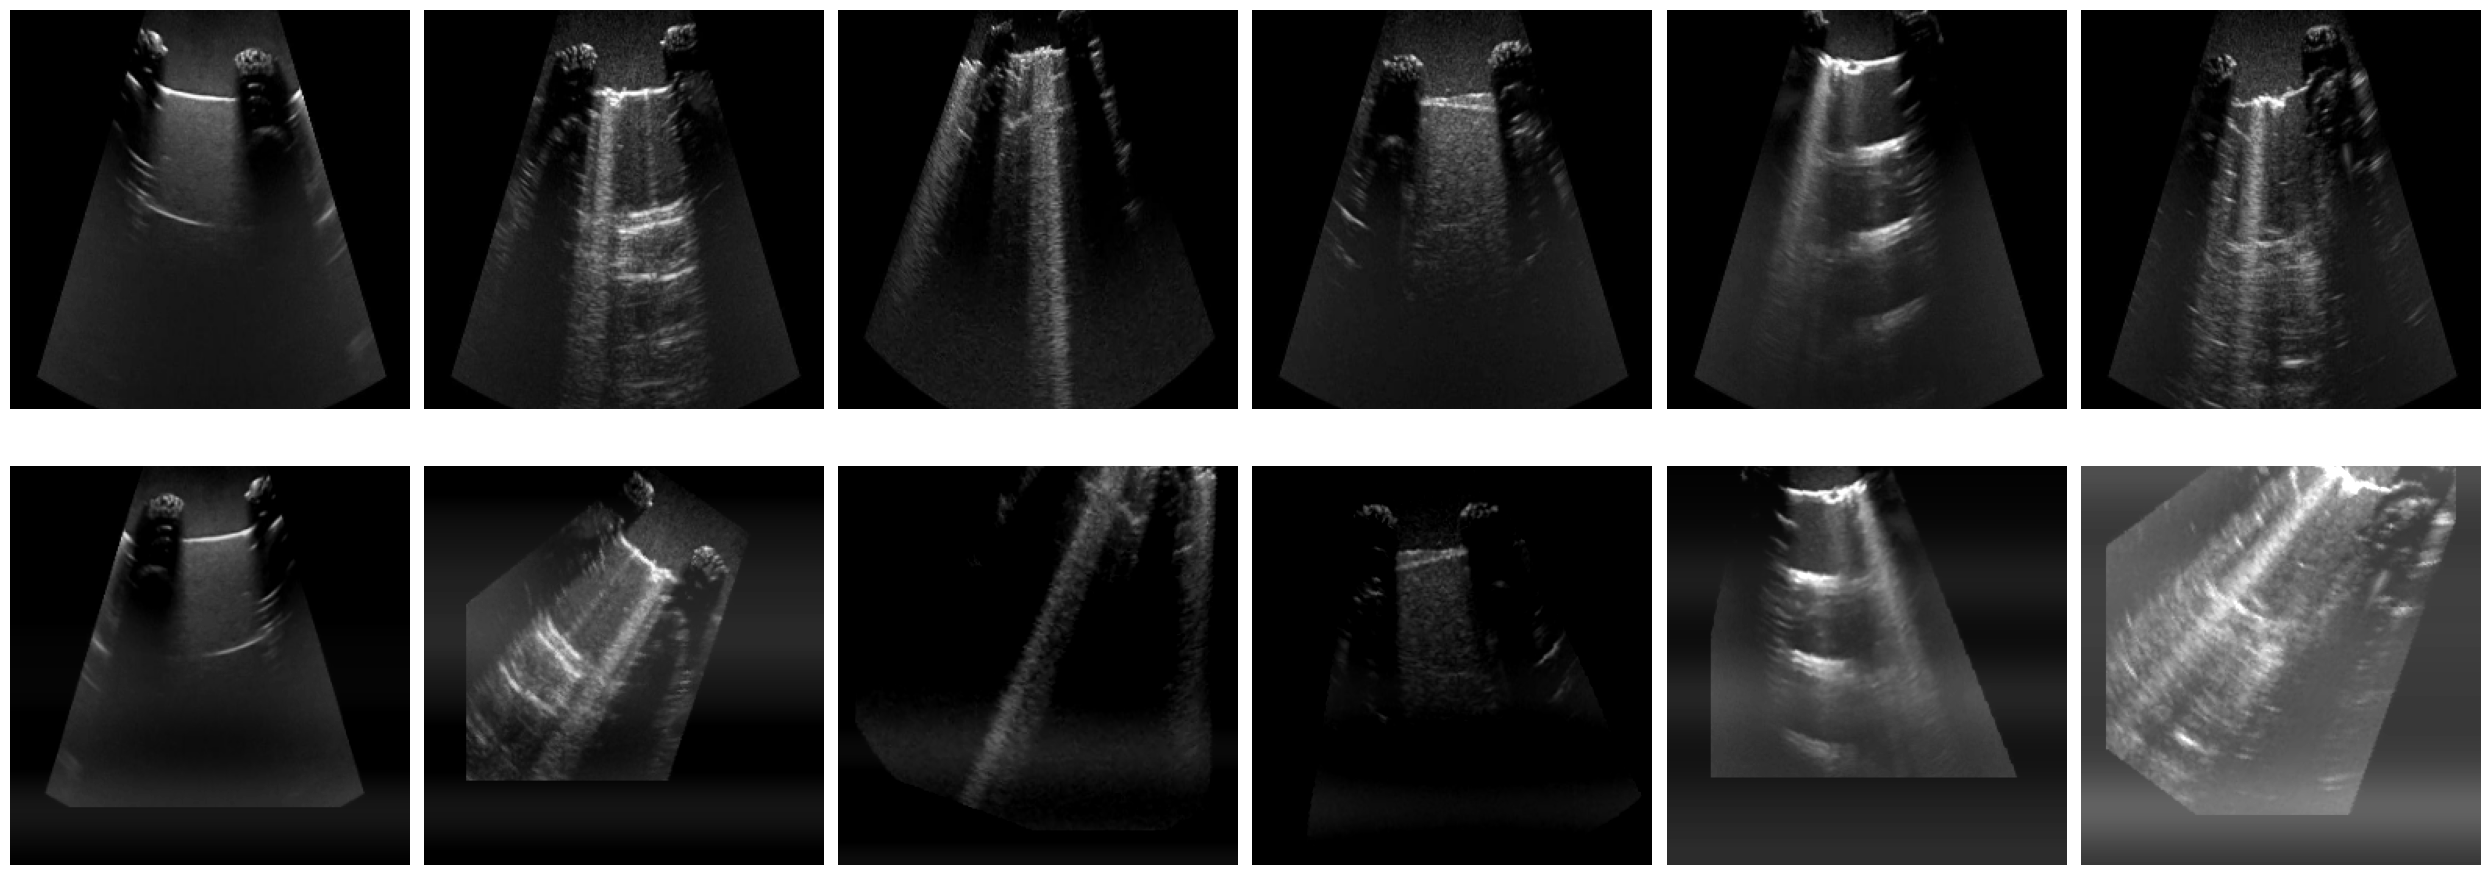

9638

In [5]:
# Run this cell multiple times to generate transformations
n_display = 6

# Temporary dataloaders to display augmentations. These will be deleted at the end of the cell
dl_tmp = DataLoader(image_paths=valid_im_paths,
                     mask_paths=valid_mask_paths,
                     n_classes=num_classes,
                     channels=(1, 1),
                     augment=False,
                     shuffle=False,
                     d_transforms=d_transforms,
                     seed=47).build_dataloader()

dl_tmp2 = DataLoader(image_paths=valid_im_paths,
                     mask_paths=valid_mask_paths,
                     n_classes=num_classes,
                     channels=(1, 1),
                     augment=True,
                     shuffle=False,
                     d_transforms=d_transforms,
                     d_augs=d_augs,
                     seed=47).build_dataloader()

fig, axs = plt.subplots(2,n_display, figsize=(25,10))

for i, (image, mask) in enumerate(dl_tmp):   
    # Plot images without augmentations
    axs[0,i].axis('off')
    ax = axs[0,i].imshow(image.numpy()[0,:,:,:], cmap='gray')
    ax.set_clim(0,1)
    
    if i+1 == n_display:
        break
    
for i, (image, mask) in enumerate(dl_tmp2):
    # Plot images with augmentations
    axs[1,i].axis('off')
    ax = axs[1,i].imshow(image.numpy()[0,:,:,:], cmap='gray')
    ax.set_clim(0,1)
    
    if i+1 == n_display:
        break

plt.tight_layout()
plt.show()

del dl_tmp, dl_tmp2
gc.collect()

In [6]:
# Training dataloader (with augmentations)
dl_train = DataLoader(image_paths=train_im_paths,
                     mask_paths=train_mask_paths,
                     n_classes=num_classes,
                     channels=(1, 1),
                     augment=True,
                     shuffle=True,
                     d_transforms=d_transforms,
                     d_augs=d_augs,
                     batch_size=batch_size,
                     seed=47).build_dataloader()

# Validation dataloader (without augmentations)
dl_valid = DataLoader(image_paths=valid_im_paths,
                     mask_paths=valid_mask_paths,
                     n_classes=num_classes,
                     channels=(1, 1),
                     augment=False, # No augs
                     shuffle=True,
                     d_transforms=d_transforms,
                     batch_size=batch_size,
                     seed=47).build_dataloader()


## Model definintion

In [7]:
# Hyperparameters
epochs = 200 # number of epochs
lr = 1e-4 # learning rate
loss_fn = loss.combined_ce_dice_loss # choose a loss function from available loss functions

################################################################################################

loss.loss_functions_map('print')

Available loss functions: ['dice', 'iou', 'tversky', 'focal_tversky', 'cross_entropy', 'combined_ce_dice', 'combined_ce_focal_tversky']


In [8]:
# Model definition 
model = models.unet(shape, num_classes, filters=[32,64,128,256,512])
model.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Adam(lr), metrics=[metrics.dice_coef_average, metrics.IoU_average, metrics.tversky_average]) # metrics to print for validation set

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [258]:
# # Uncomment for Graphical representation (quite large)

# tf.keras.utils.plot_model(model, show_shapes=True, 
#                           show_layer_names=True,
#                           expand_nested=False, 
#                           rankdir='TB'
#                           ) 

# Model training

In [259]:
# Train the model
model_name = "model_lus_new"

timetaken = metrics.timecallback() # Callback to measure the time elapsed per epoch
callbacks = [
    ModelCheckpoint(model_name+'.h5', monitor='val_loss', verbose=0, save_best_model=True),           # Save the best model checkpoint
    ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.5, verbose=1, min_lr=1e-6),      # Dynamic learning rate
    EarlyStopping(monitor="val_loss", patience=15, verbose=1),                                   # Early stopping to prevent overfitting
    TensorBoard(log_dir='logs'),                                                                # Integrate with tenorboard
    timetaken                                                                                   # Record the time elapsed per epoch
]

history = model.fit(dl_train,
                    validation_data=dl_valid,
                    epochs=epochs,
                    callbacks=callbacks,
                    workers=4,
                    use_multiprocessing=True,
)

# Can monitor training progress using tensorboard if installed
# %tensorboard --logdir logs

Epoch 1/200
 6/47 [==>...........................] - ETA: 4s - loss: 1.3911 - dice_coef_average: 0.0554 - IoU_average: 0.0302 - tversky_average: 0.0552WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0577s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


47/47 [==============================] - 11s 156ms/step - loss: 1.2447 - dice_coef_average: 0.0703 - IoU_average: 0.0400 - tversky_average: 0.0684 - val_loss: 3.0867 - val_dice_coef_average: 0.0355 - val_IoU_average: 0.0183 - val_tversky_average: 0.0400 - lr: 1.0000e-04
Epoch 2/200
47/47 [==============================] - 7s 138ms/step - loss: 1.0861 - dice_coef_average: 0.0916 - IoU_average: 0.0550 - tversky_average: 0.0885 - val_loss: 1.1275 - val_dice_coef_average: 0.0793 - val_IoU_average: 0.0472 - val_tversky_average: 0.0741 - lr: 1.0000e-04
Epoch 3/200
47/47 [==============================] - 7s 136ms/step - loss: 1.0220 - dice_coef_average: 0.1033 - IoU_average: 0.0640 - tversky_average: 0.1001 - val_loss: 0.9882 - val_dice_coef_average: 0.0984 - val_IoU_average: 0.0633 - val_tversky_average: 0.0913 - lr: 1.0000e-04
Epoch 4/200
47/47 [==============================] - 7s 134ms/step - loss: 0.9768 - dice_coef_average: 0.1144 - IoU_average: 0.0725 - tversky_average: 0.1121 - val_l

In [260]:
# Save the training history
df_history=pd.DataFrame(history.history)
df_history['time']= np.array(timetaken.times)[:,1]
df_history['timetaken']=np.diff(np.array(timetaken.times)[:,1],prepend=0)

df_history.to_csv('outputs/history.csv')

# Save the final model to a .pb
# !mkdir -p saved_model
# model.save('saved_model/{}'.format(model_name))

INFO:tensorflow:Assets written to: saved_model/model_2-06/assets


INFO:tensorflow:Assets written to: saved_model/model_2-06/assets


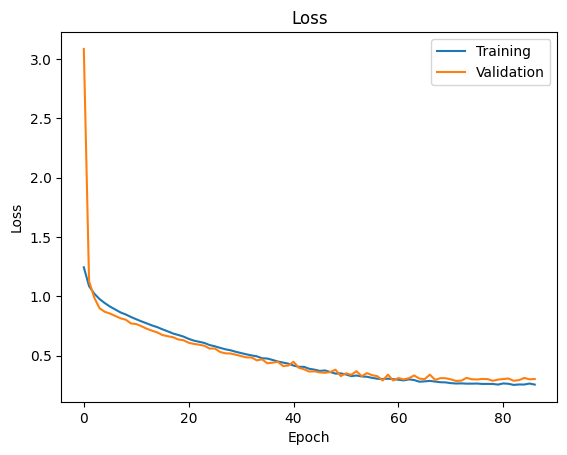

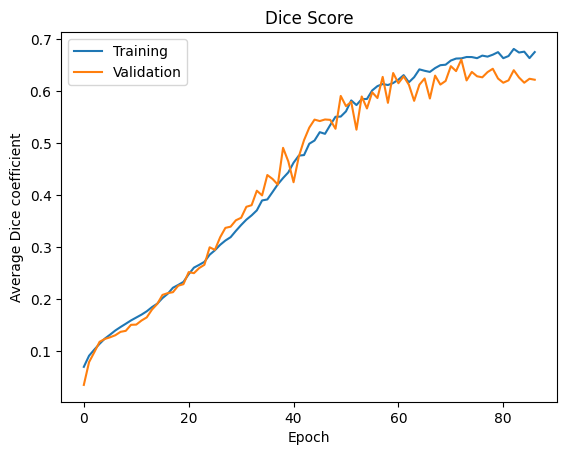

In [261]:
# Plot training history
plt.plot(df_history['loss'], label='Training')
plt.plot(df_history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.savefig('./outputs/training_loss.png')
plt.show()

plt.plot(df_history['dice_coef_average'], label='Training')
plt.plot(df_history['val_dice_coef_average'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Average Dice coefficient')
plt.legend()
plt.title('Dice Score')
plt.savefig('./outputs/training_dice.png')
plt.show()

## Model Evaluation

In [9]:
# Set up dataloader for test set
test_im_paths = prep.list_files('./data/test/images/',ext='.png')
test_mask_paths = prep.list_files('./data/test/masks/',ext='.png')

d_transforms = {'crop':(100,50,850,460),    # (x1, y1, x2, y2) 
                'resize':(256,256),         # (width, height) 
                'one-hot':True              # for mask
                                 }

dl_test = DataLoader(image_paths=test_im_paths,
                     mask_paths=test_mask_paths,
                     n_classes=num_classes,
                     channels=(1, 1),
                     augment=False, # No aumentations
                     shuffle=False, # No shuffling
                     d_transforms=d_transforms,
                     batch_size=44,
                     seed=47).build_dataloader()


In [11]:
# Predict and evaluate on test set
model.load_weights('model_lus.h5') # change this to the name of the model you want to load
test_masks = model.predict(dl_test, verbose=1, workers=4, use_multiprocessing=True)
test_masks = tf.convert_to_tensor(test_masks)


3/3 [==============================] - 0s 153ms/step


In [12]:
# Evaluate the model performance
print('Test set performance:')
model.evaluate(dl_test, verbose=1, workers=4, use_multiprocessing=True)

Test set performance:
3/3 [==============================] - 2s 106ms/step - loss: 0.2447 - dice_coef_average: 0.7314 - IoU_average: 0.5961 - tversky_average: 0.7365


[0.24468985199928284,
 0.731431782245636,
 0.5960879921913147,
 0.7364726066589355]

In [13]:
# Get the test set images and masks as numpy arrays
gt_masks = []
images = []
for im, mask in dl_test.unbatch():
    gt_masks.append(mask)
    images.append(im)
    
gt_masks = np.array(gt_masks)
images = np.array(images)

np.array(test_masks).shape


(100, 256, 256, 6)

## Display prediction examples

/tmp/ipykernel_21733/3352191677.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,3, figsize=(25,10))


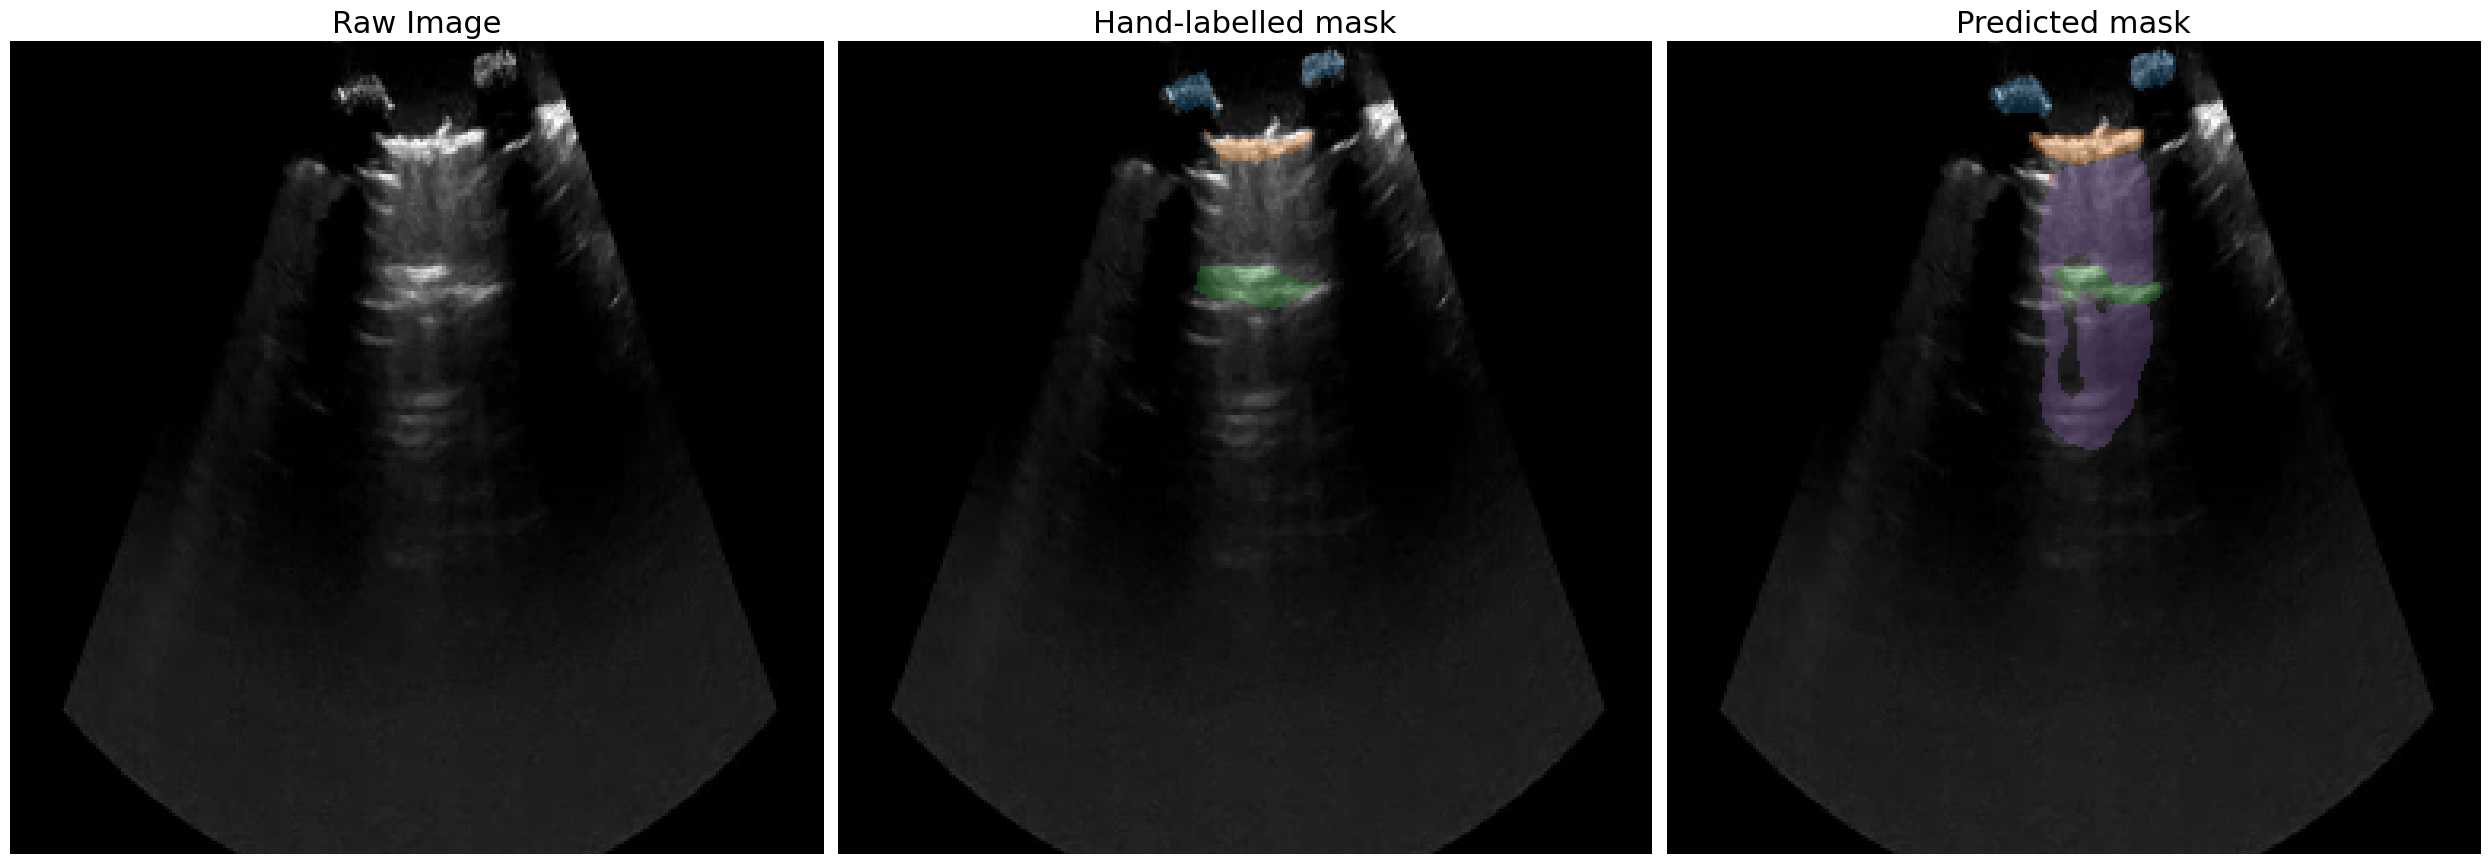

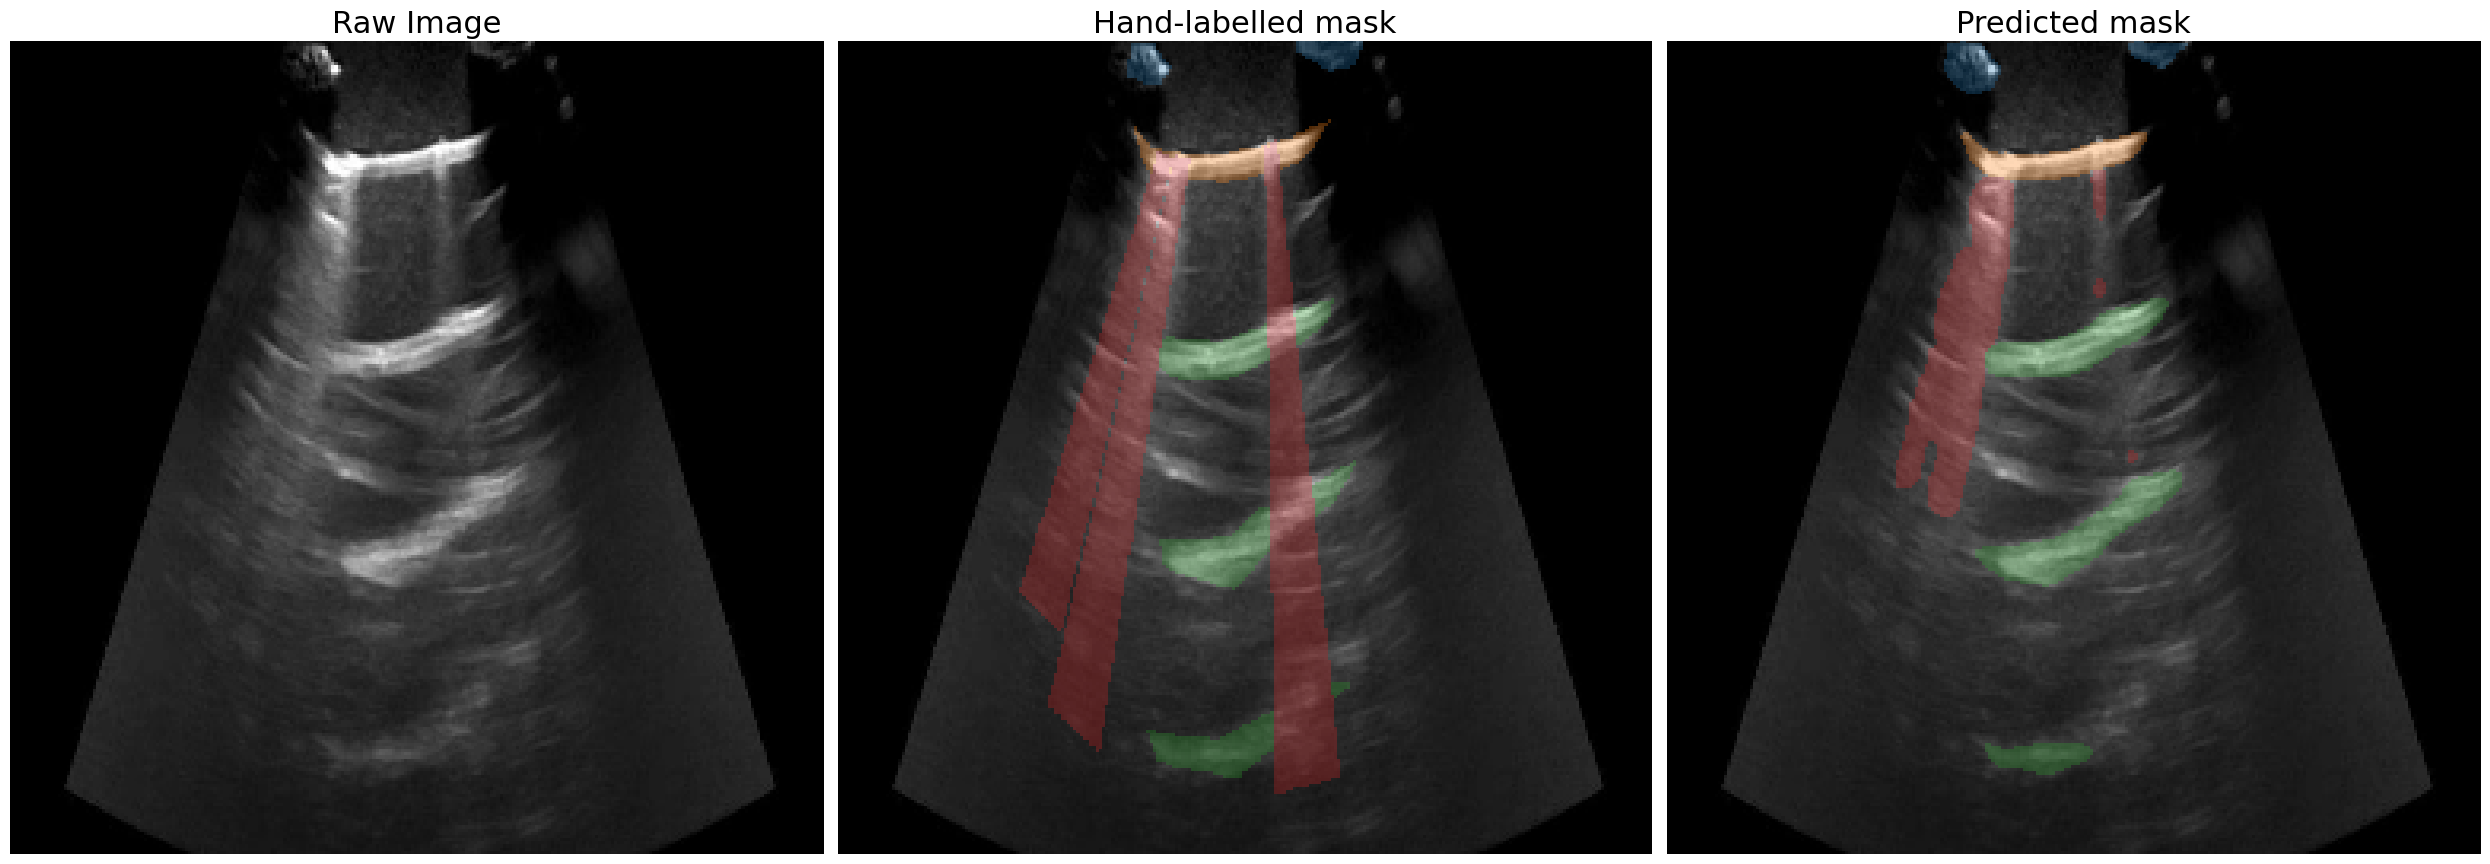

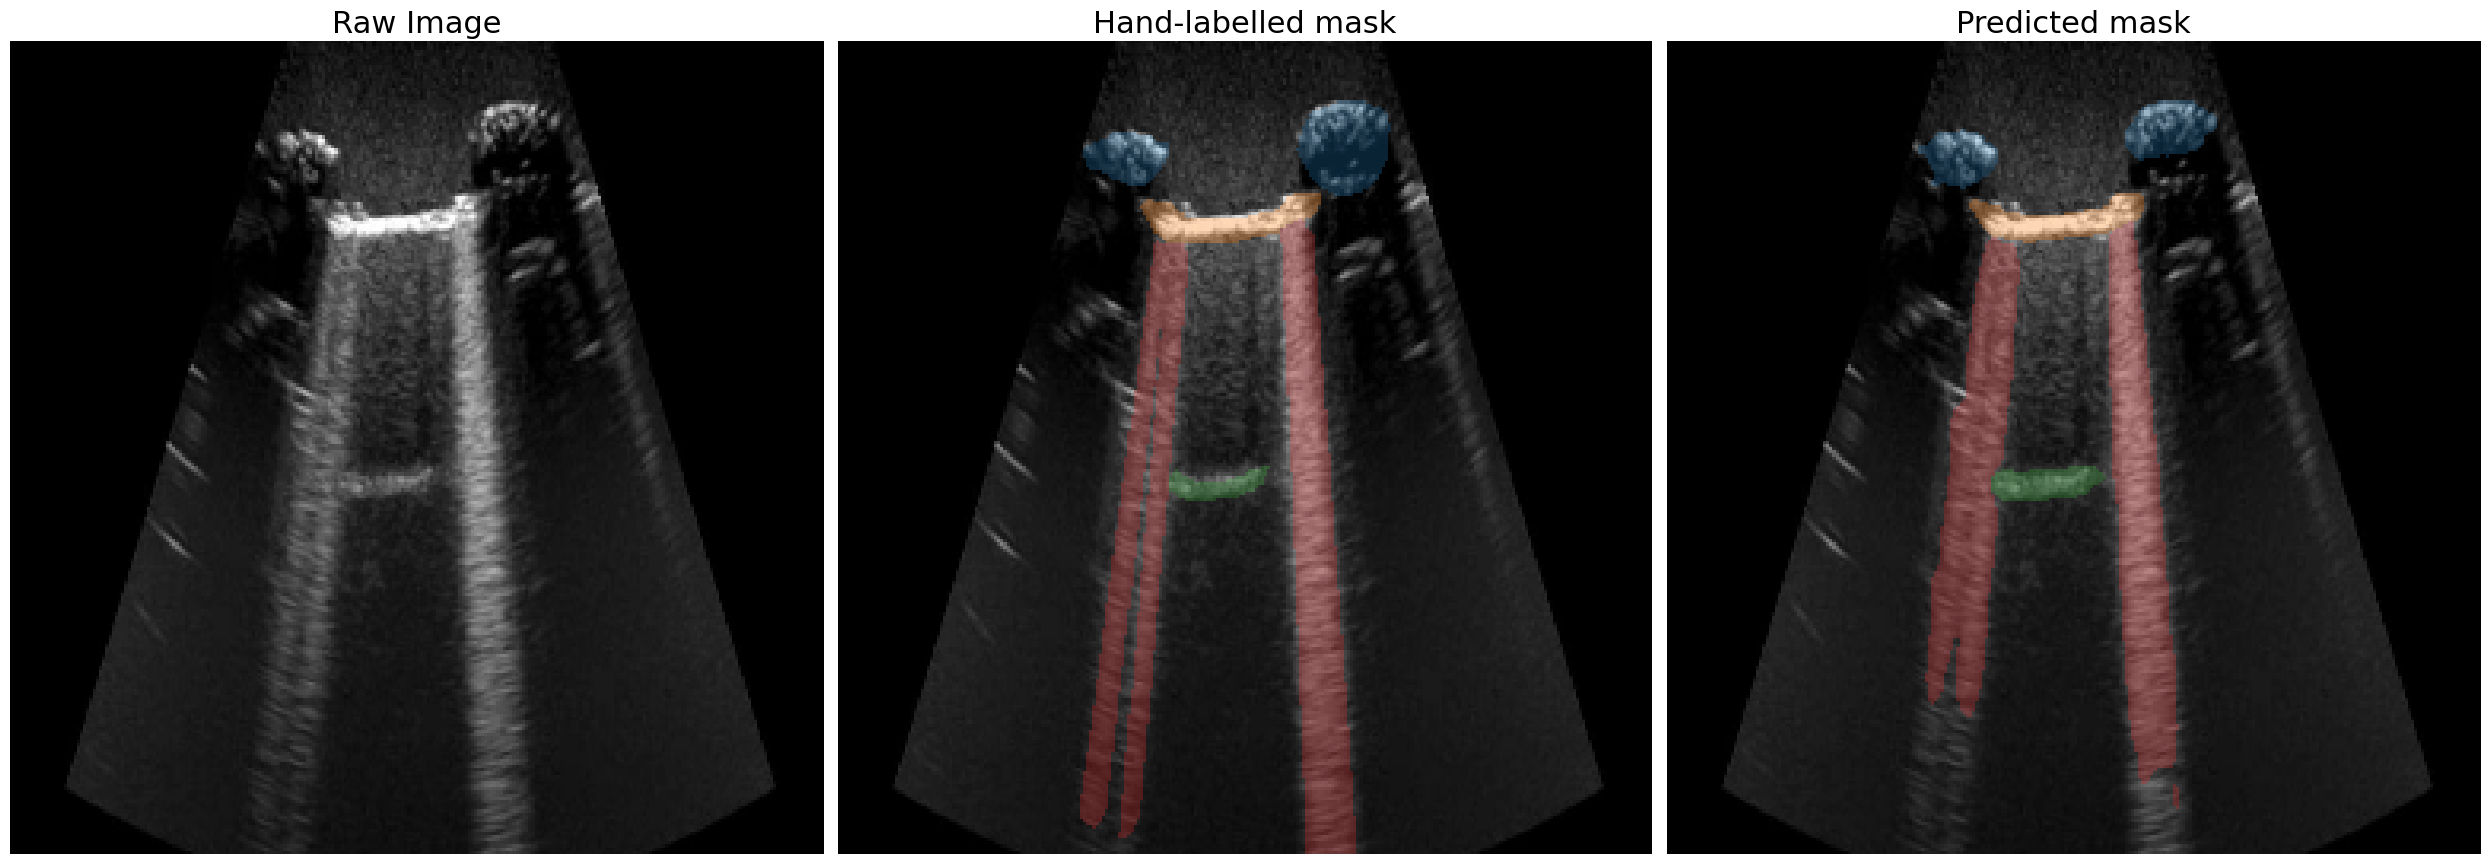

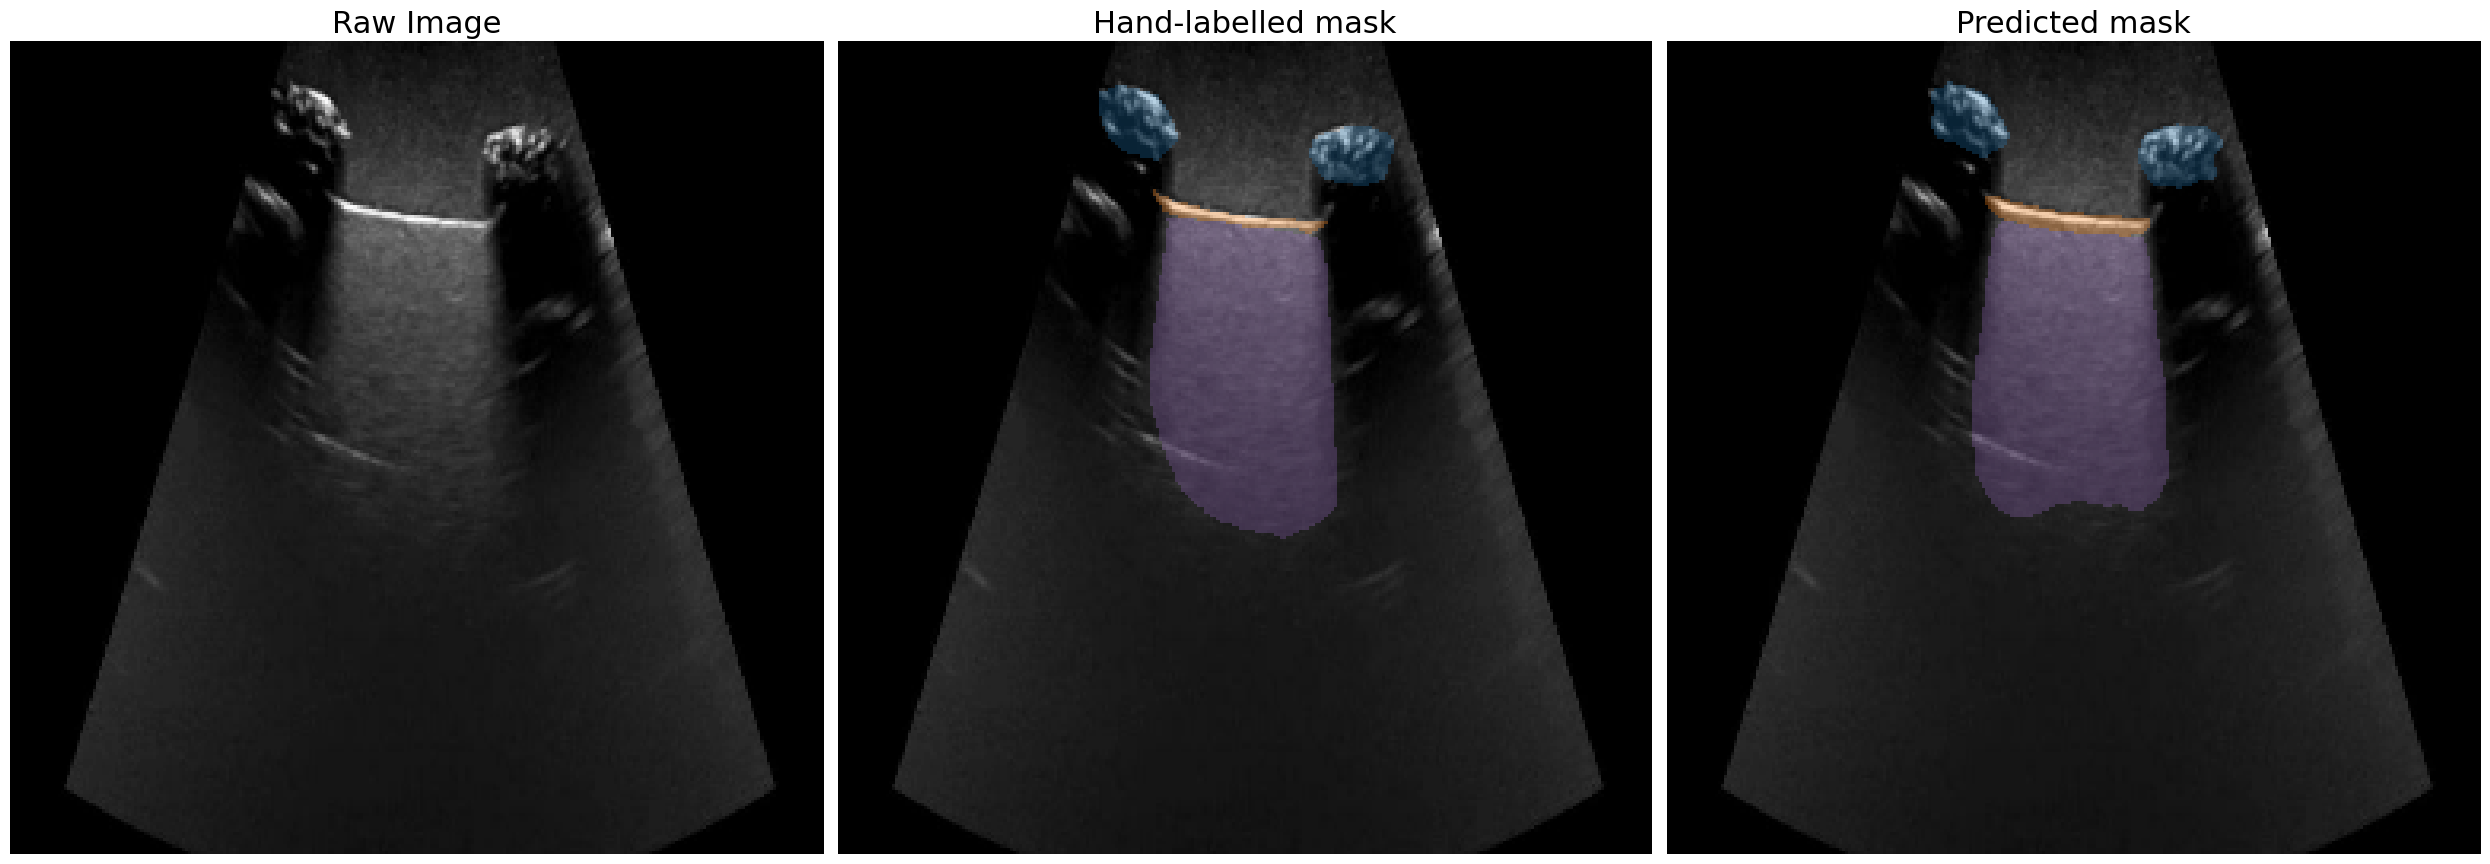

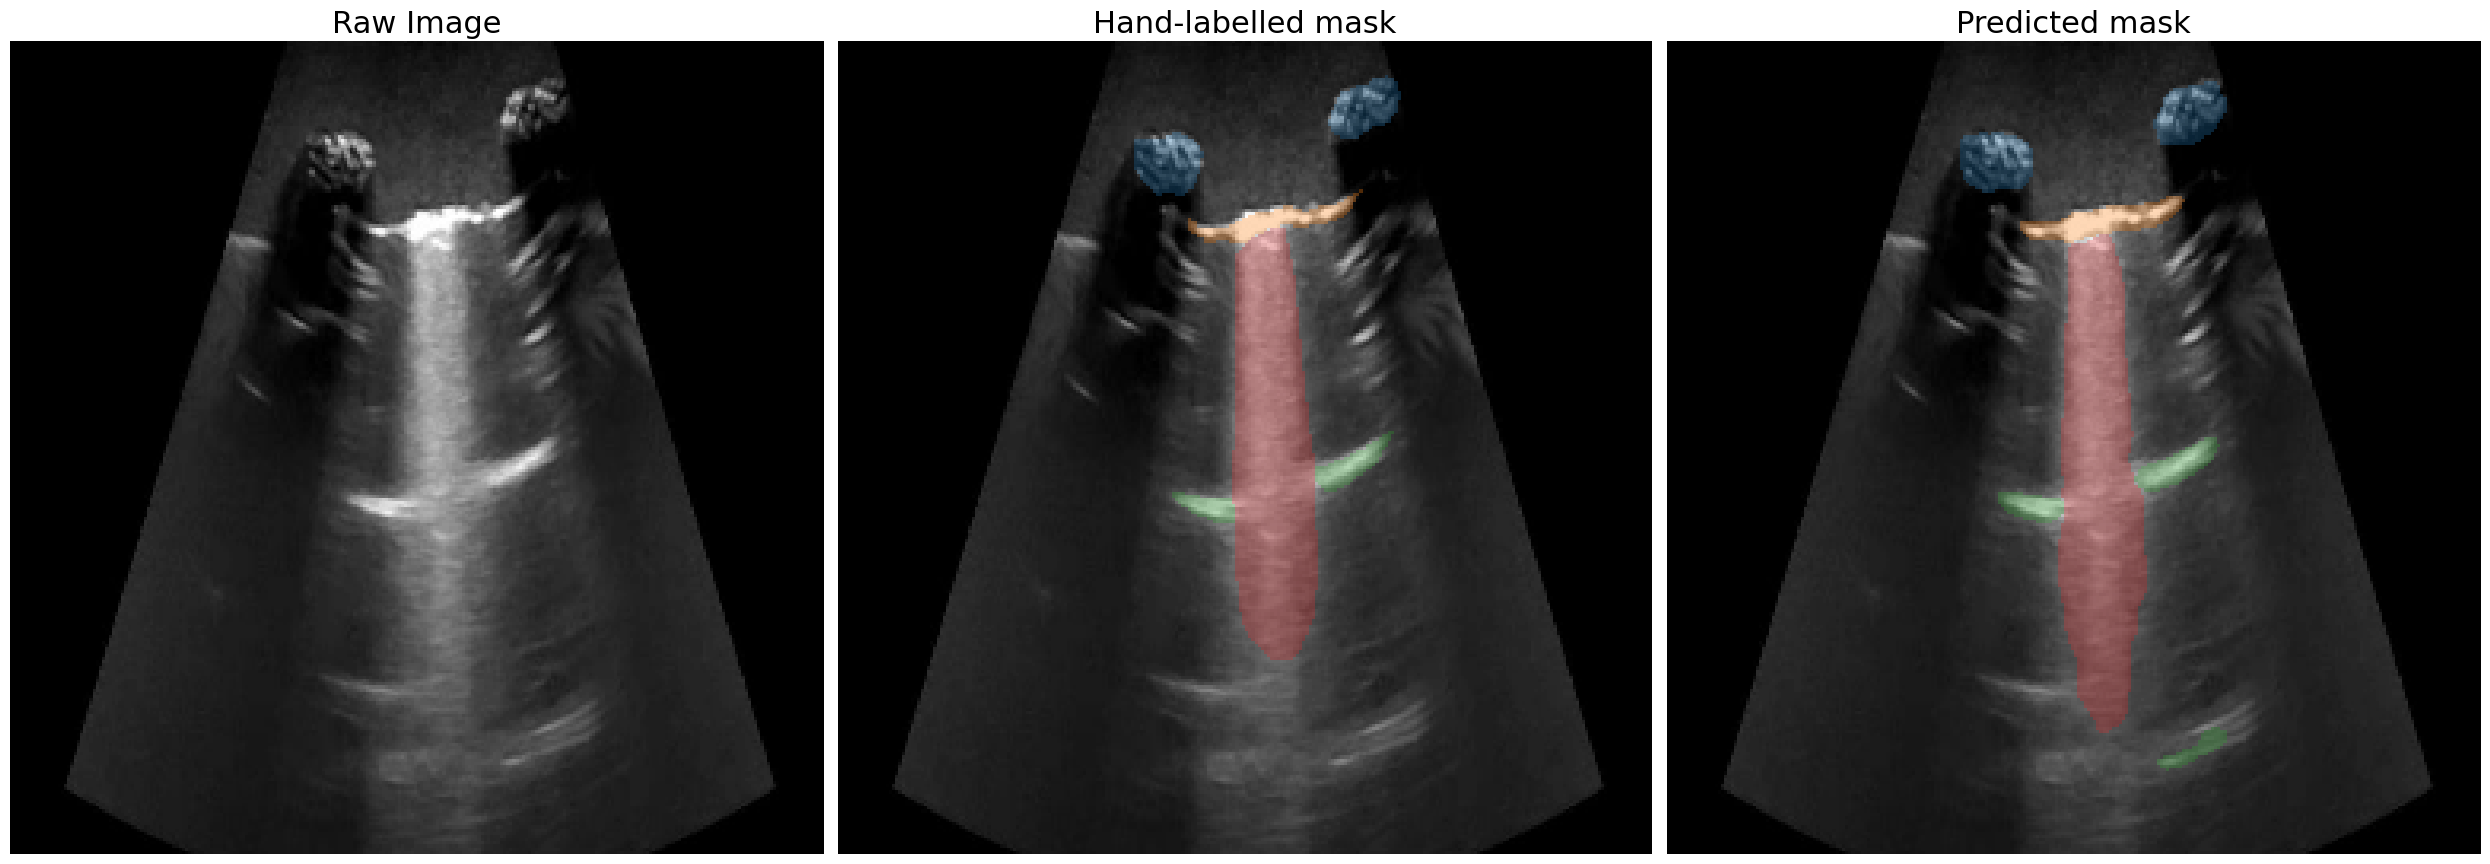

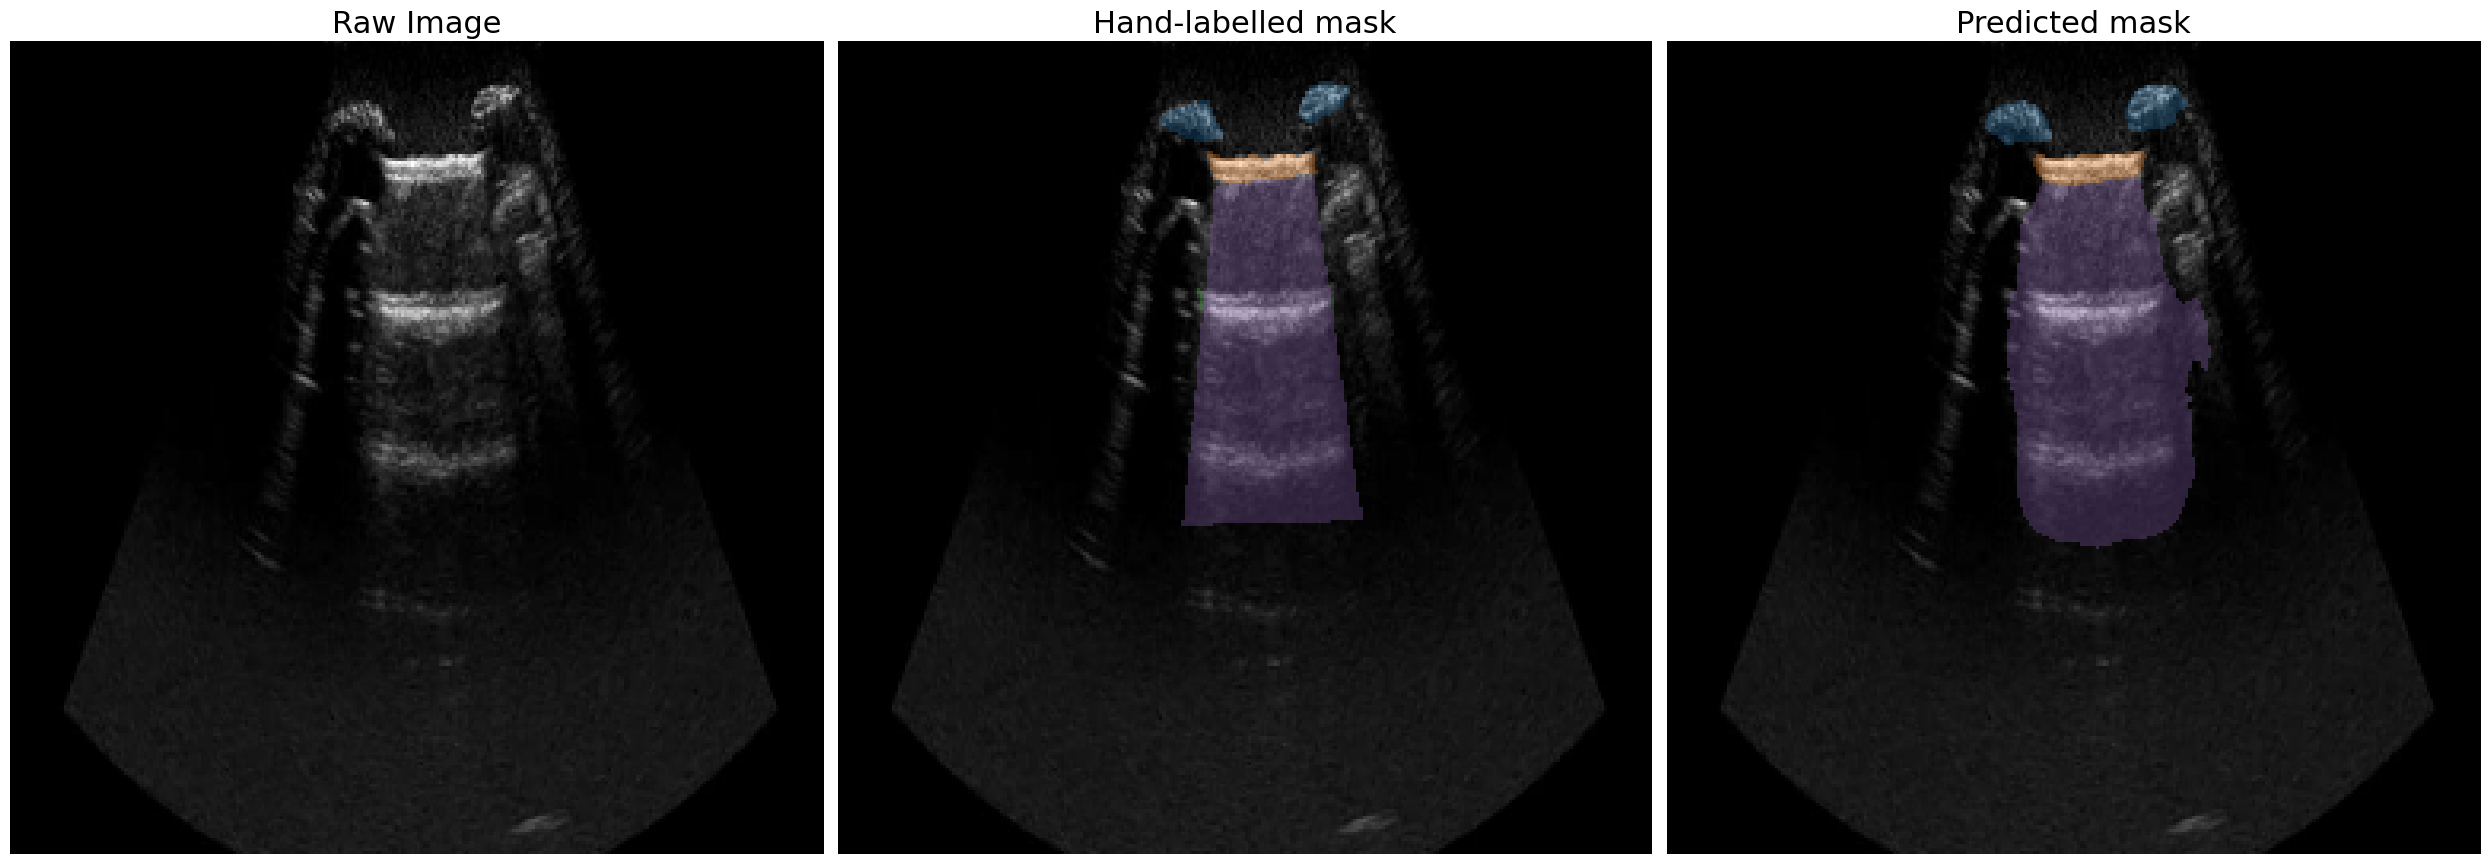

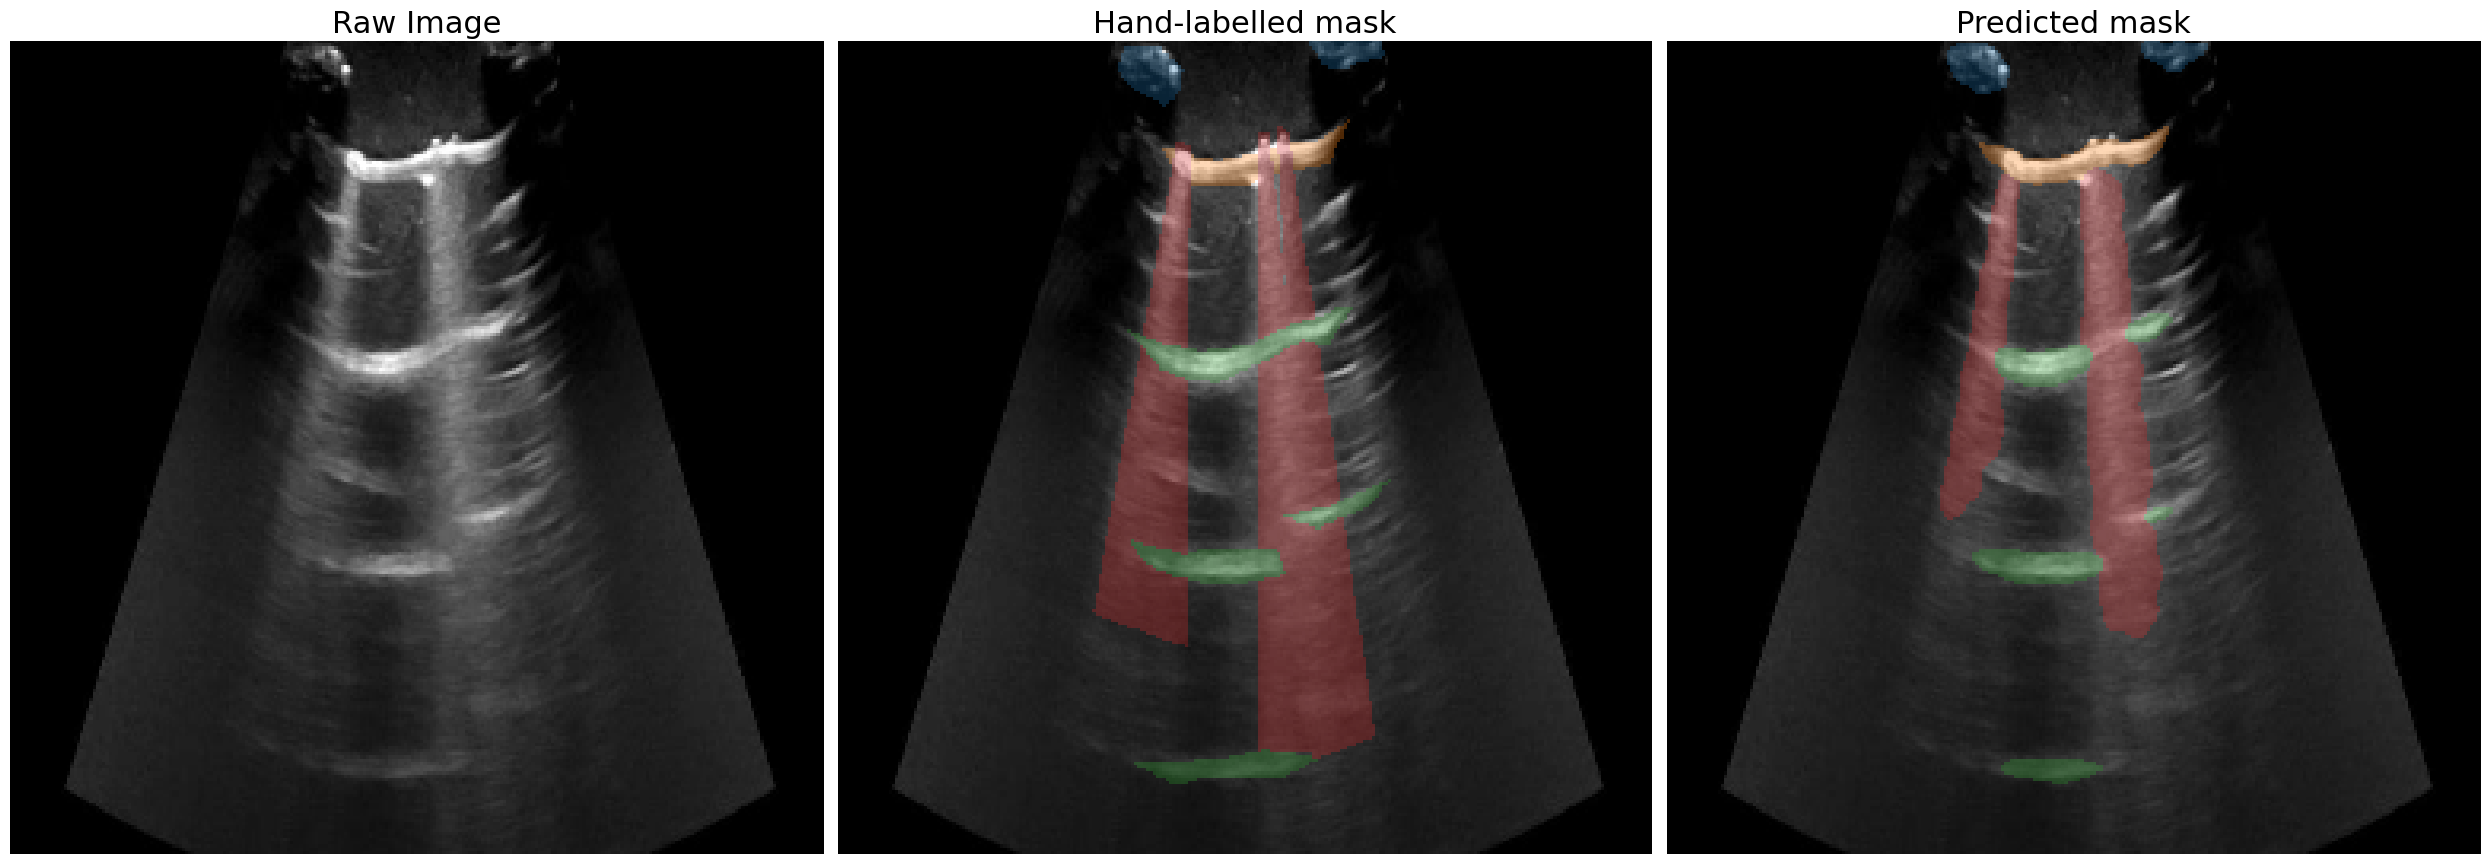

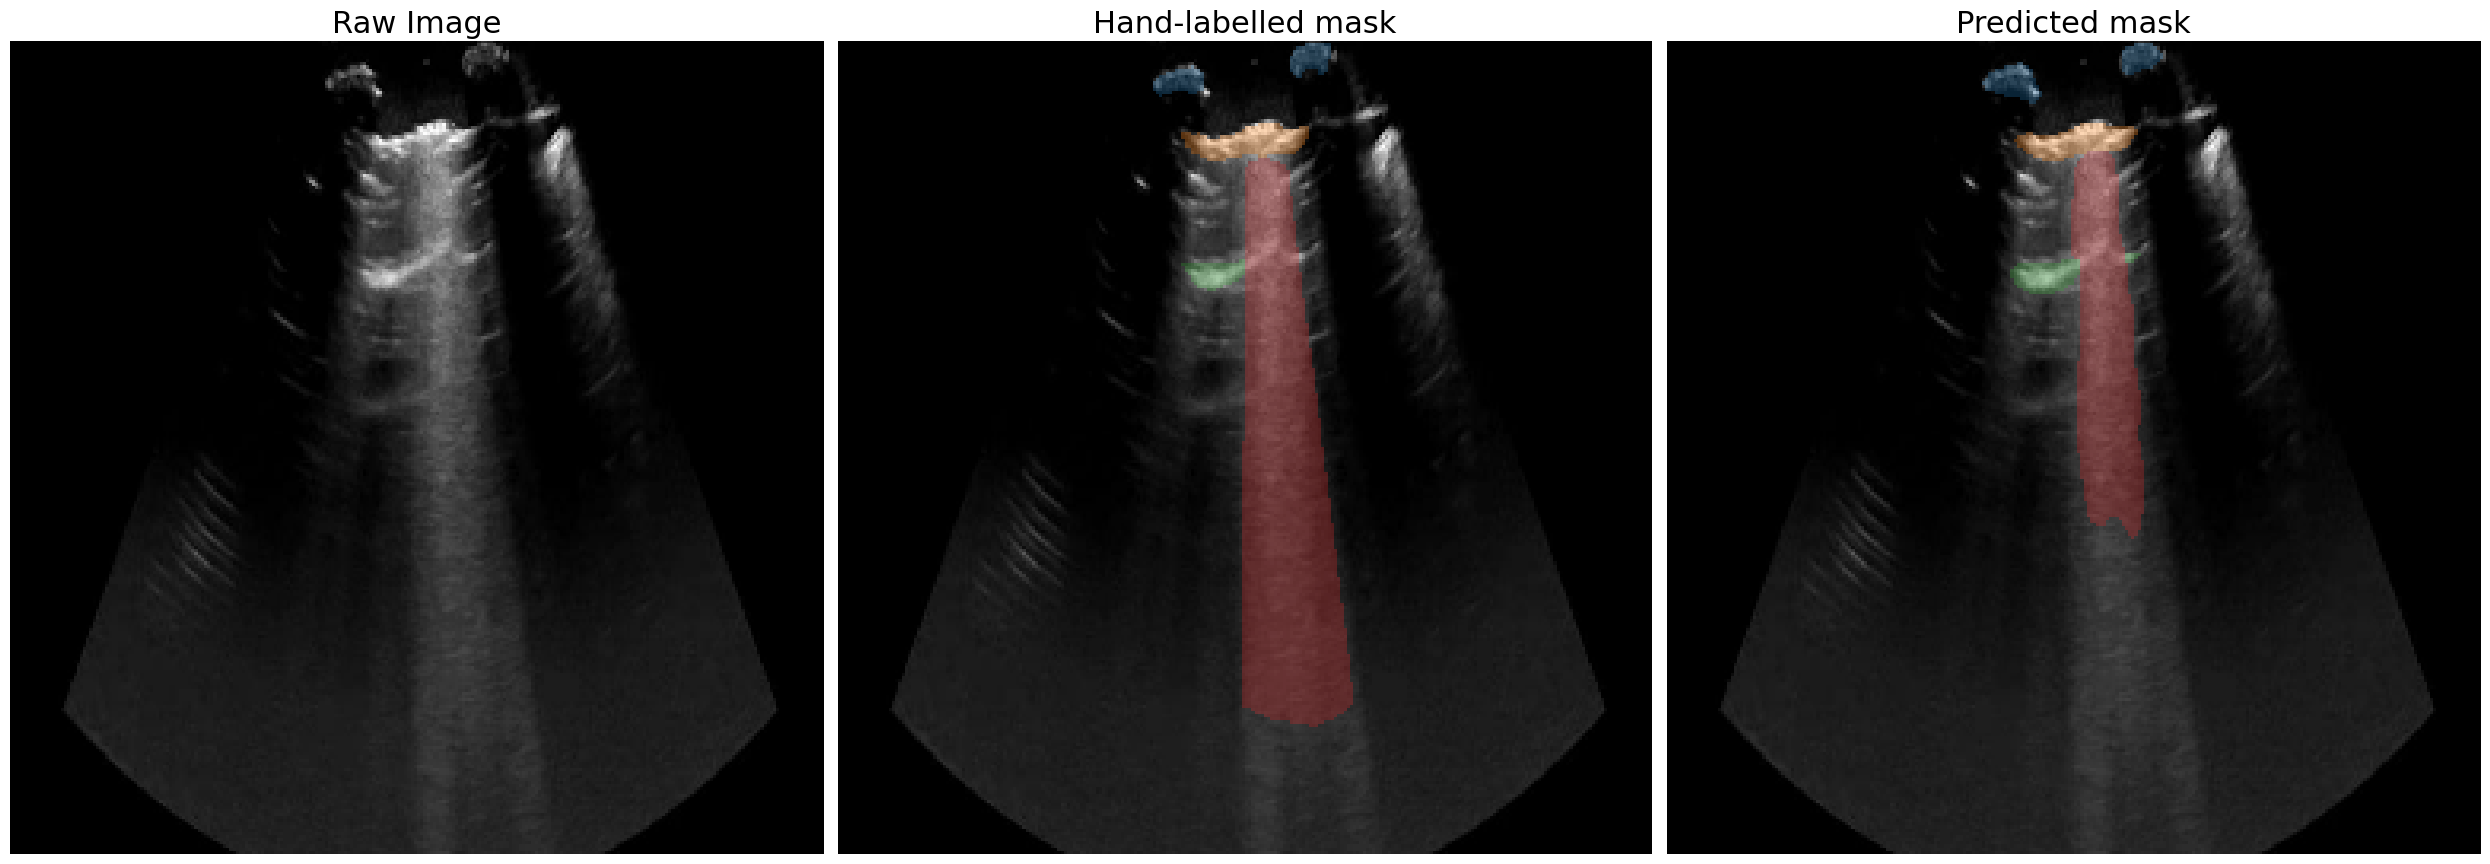

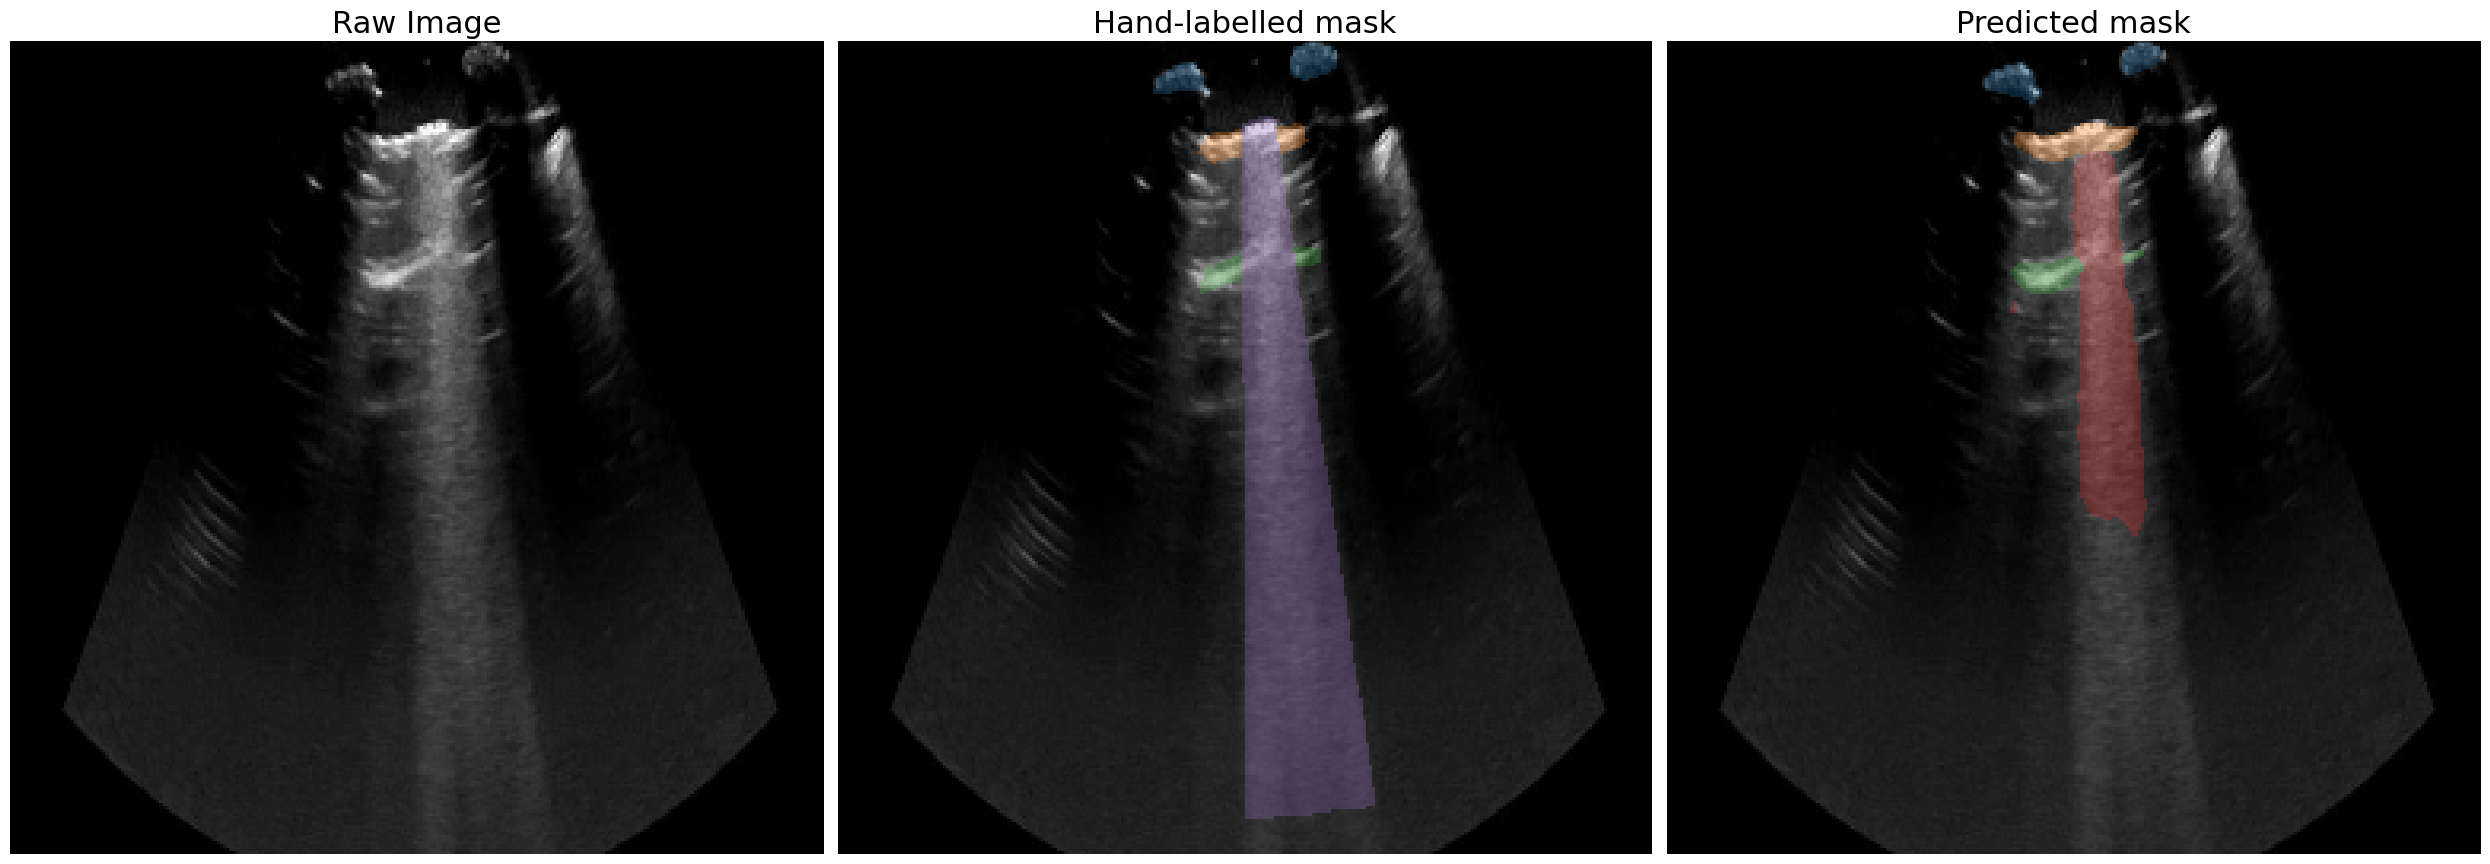

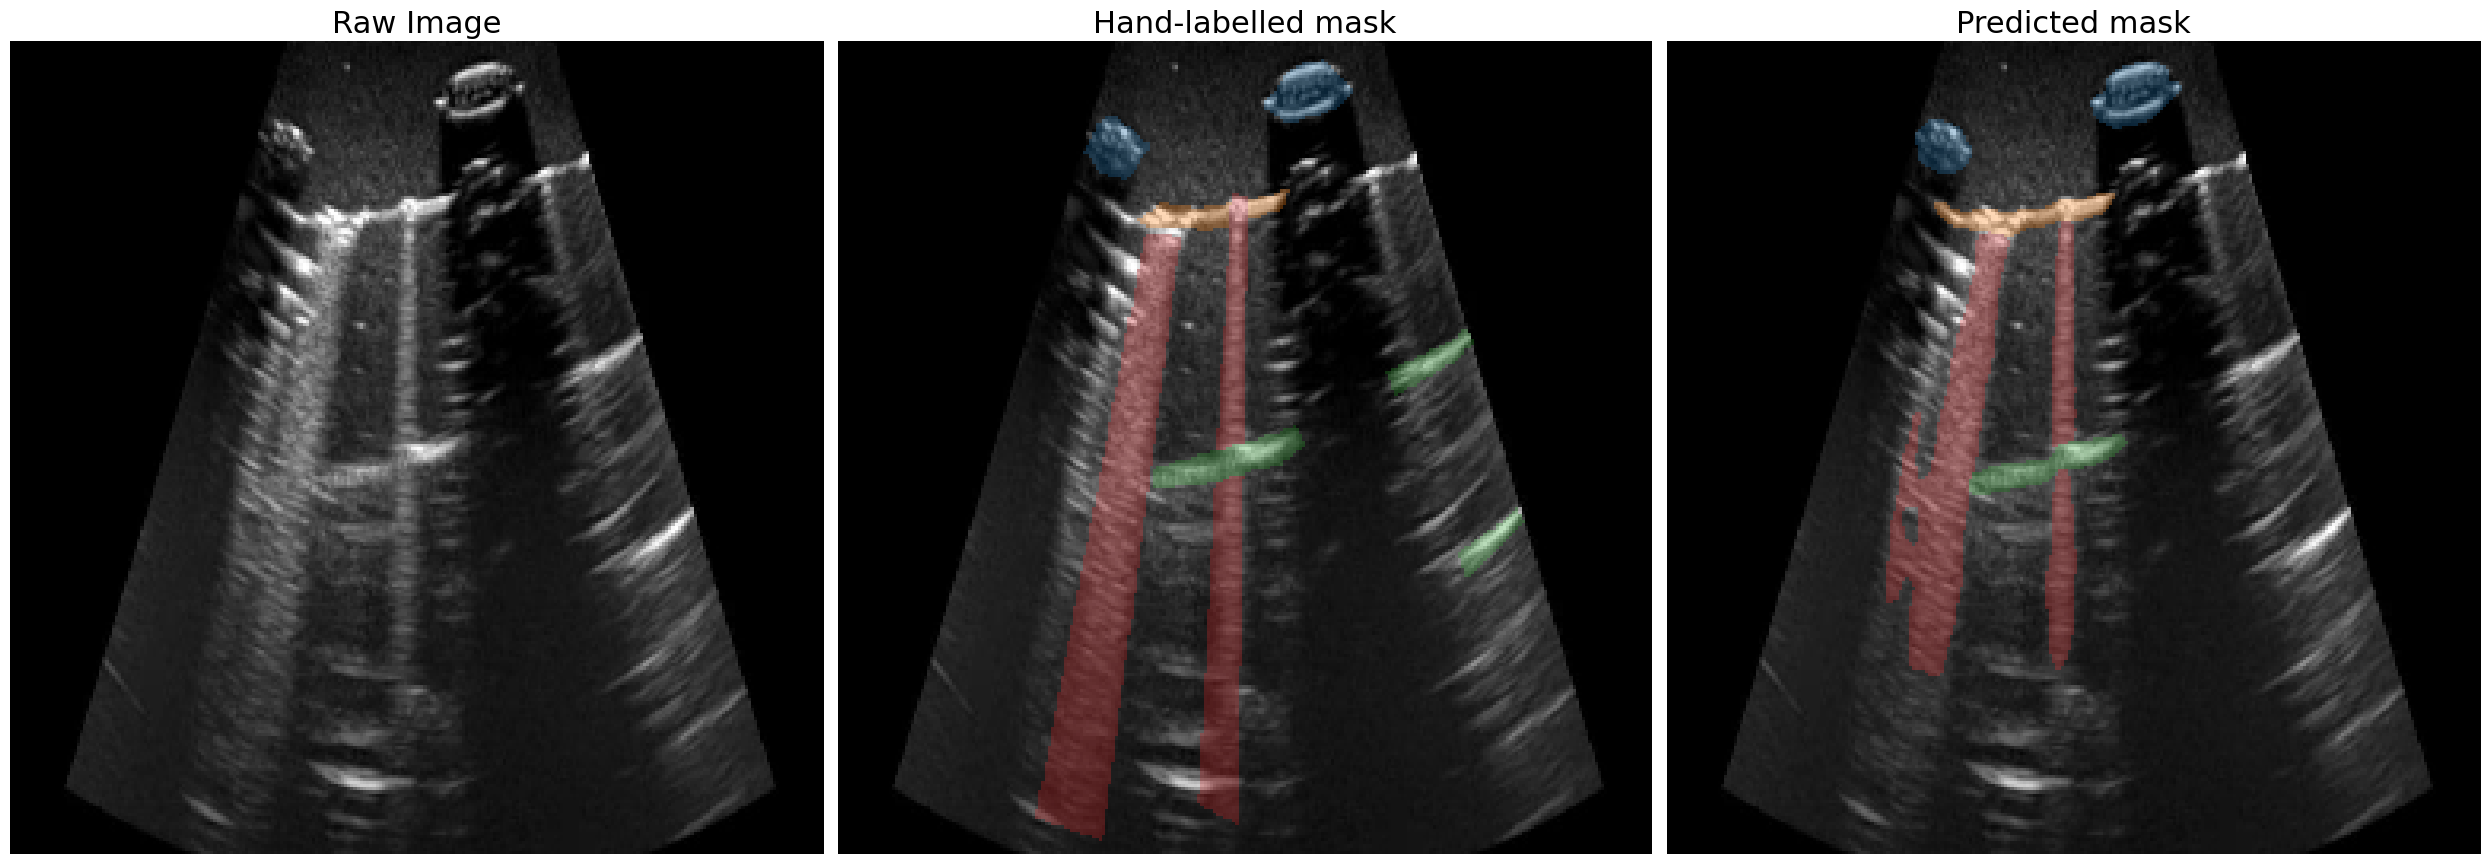

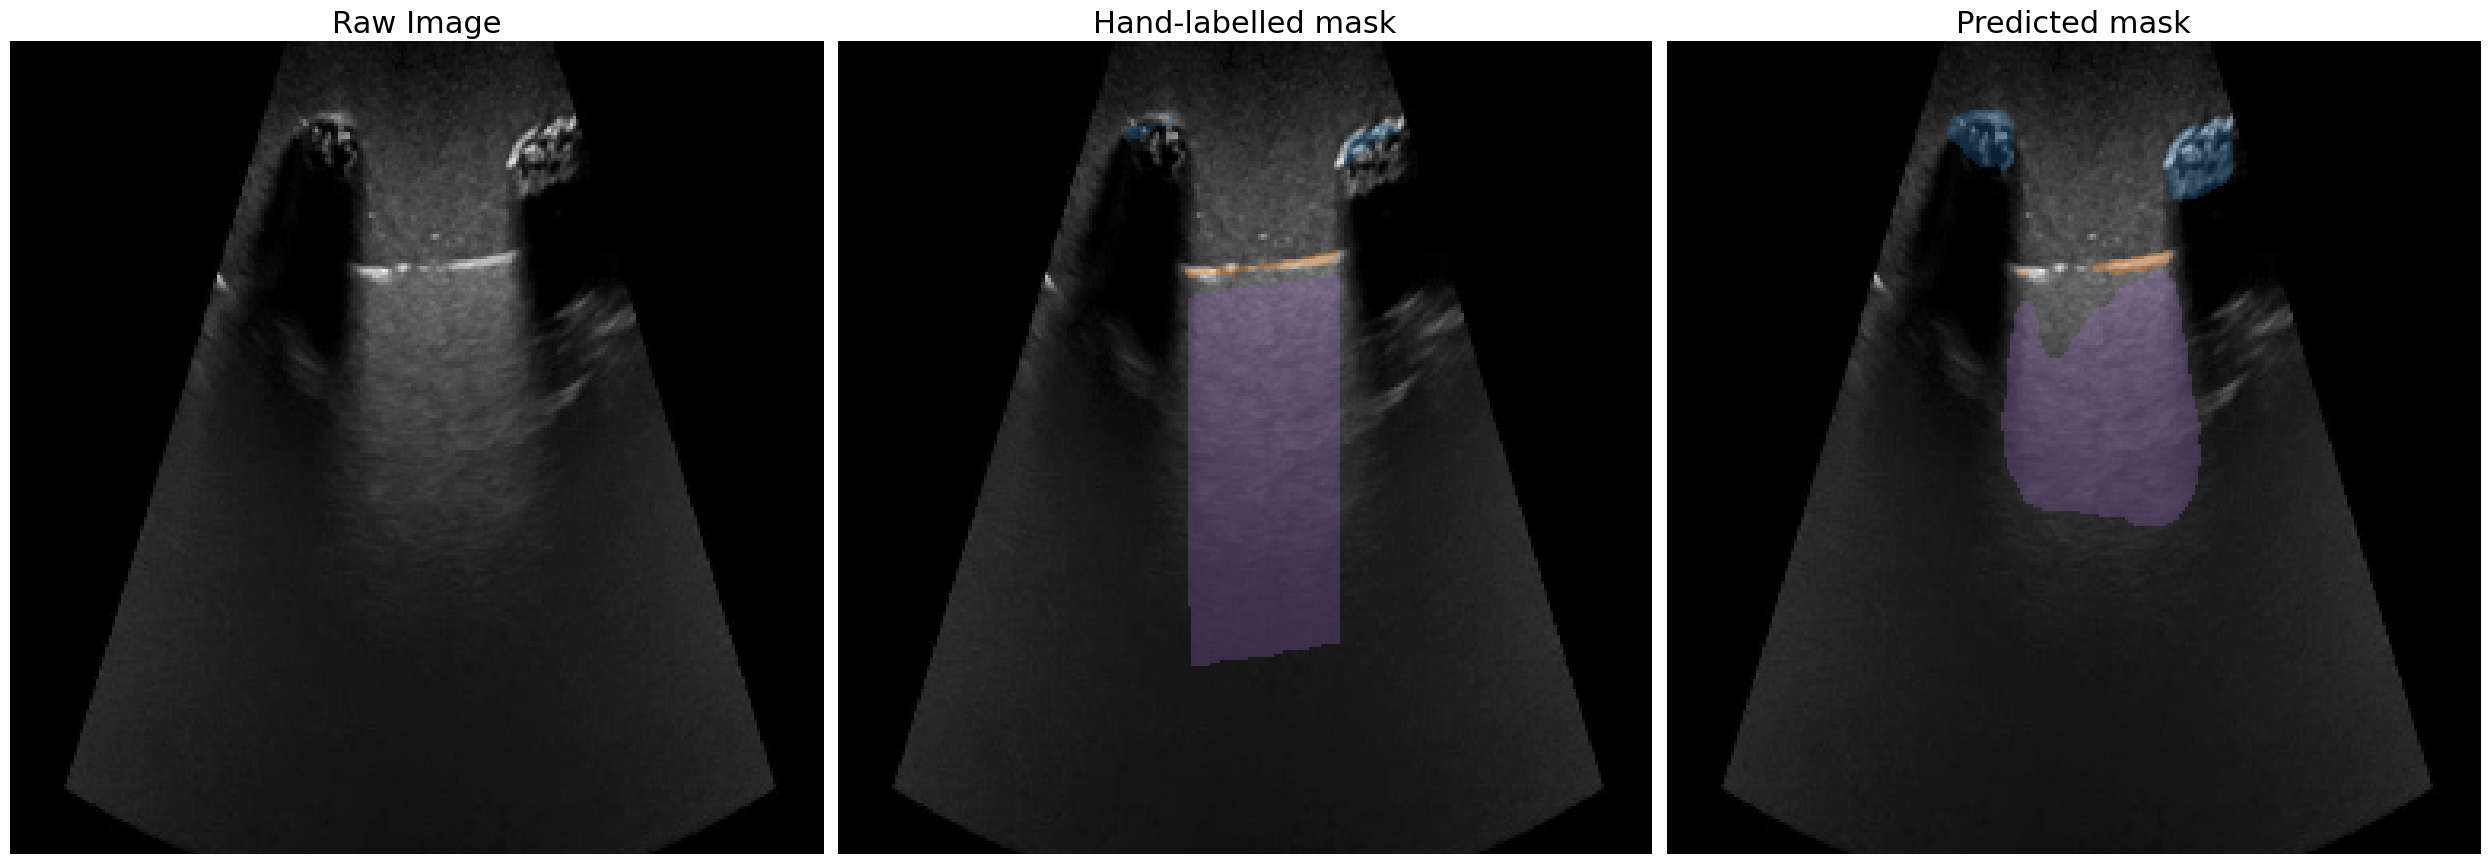

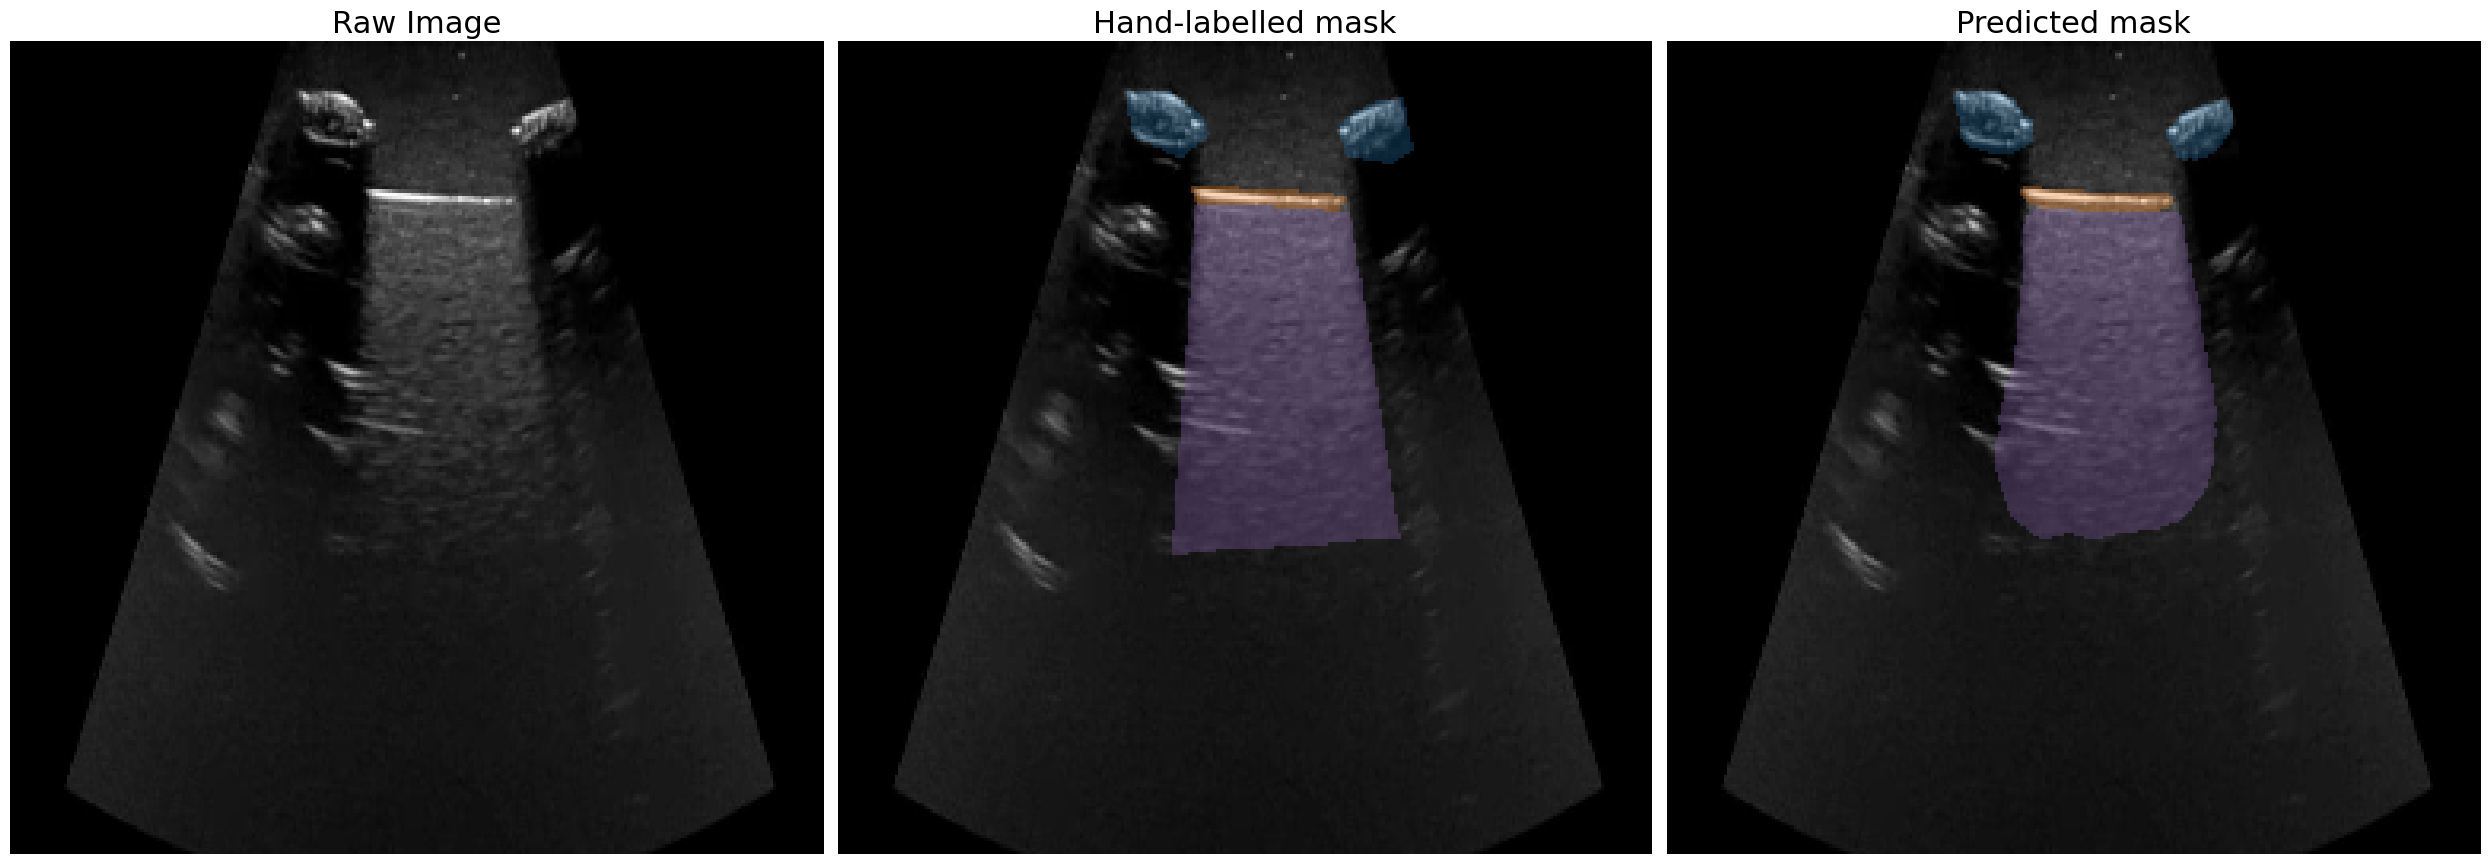

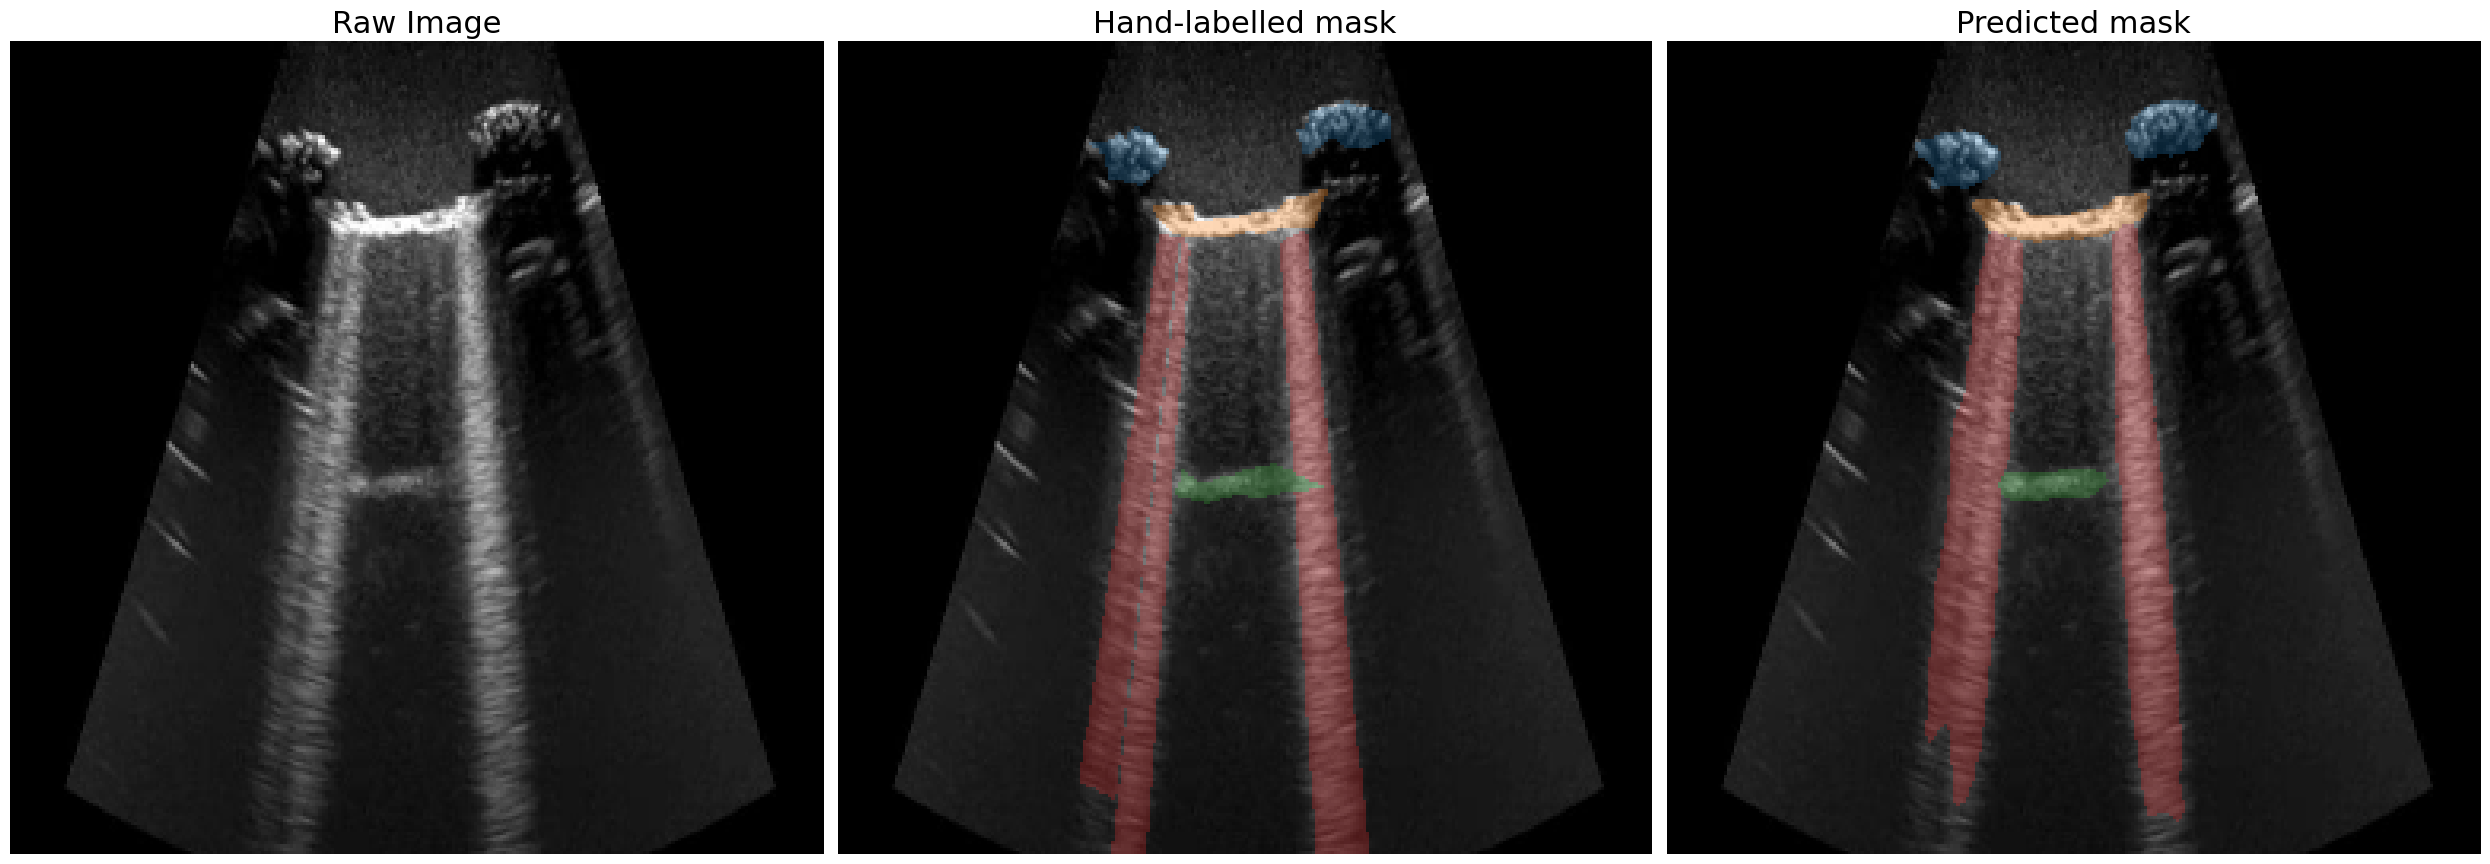

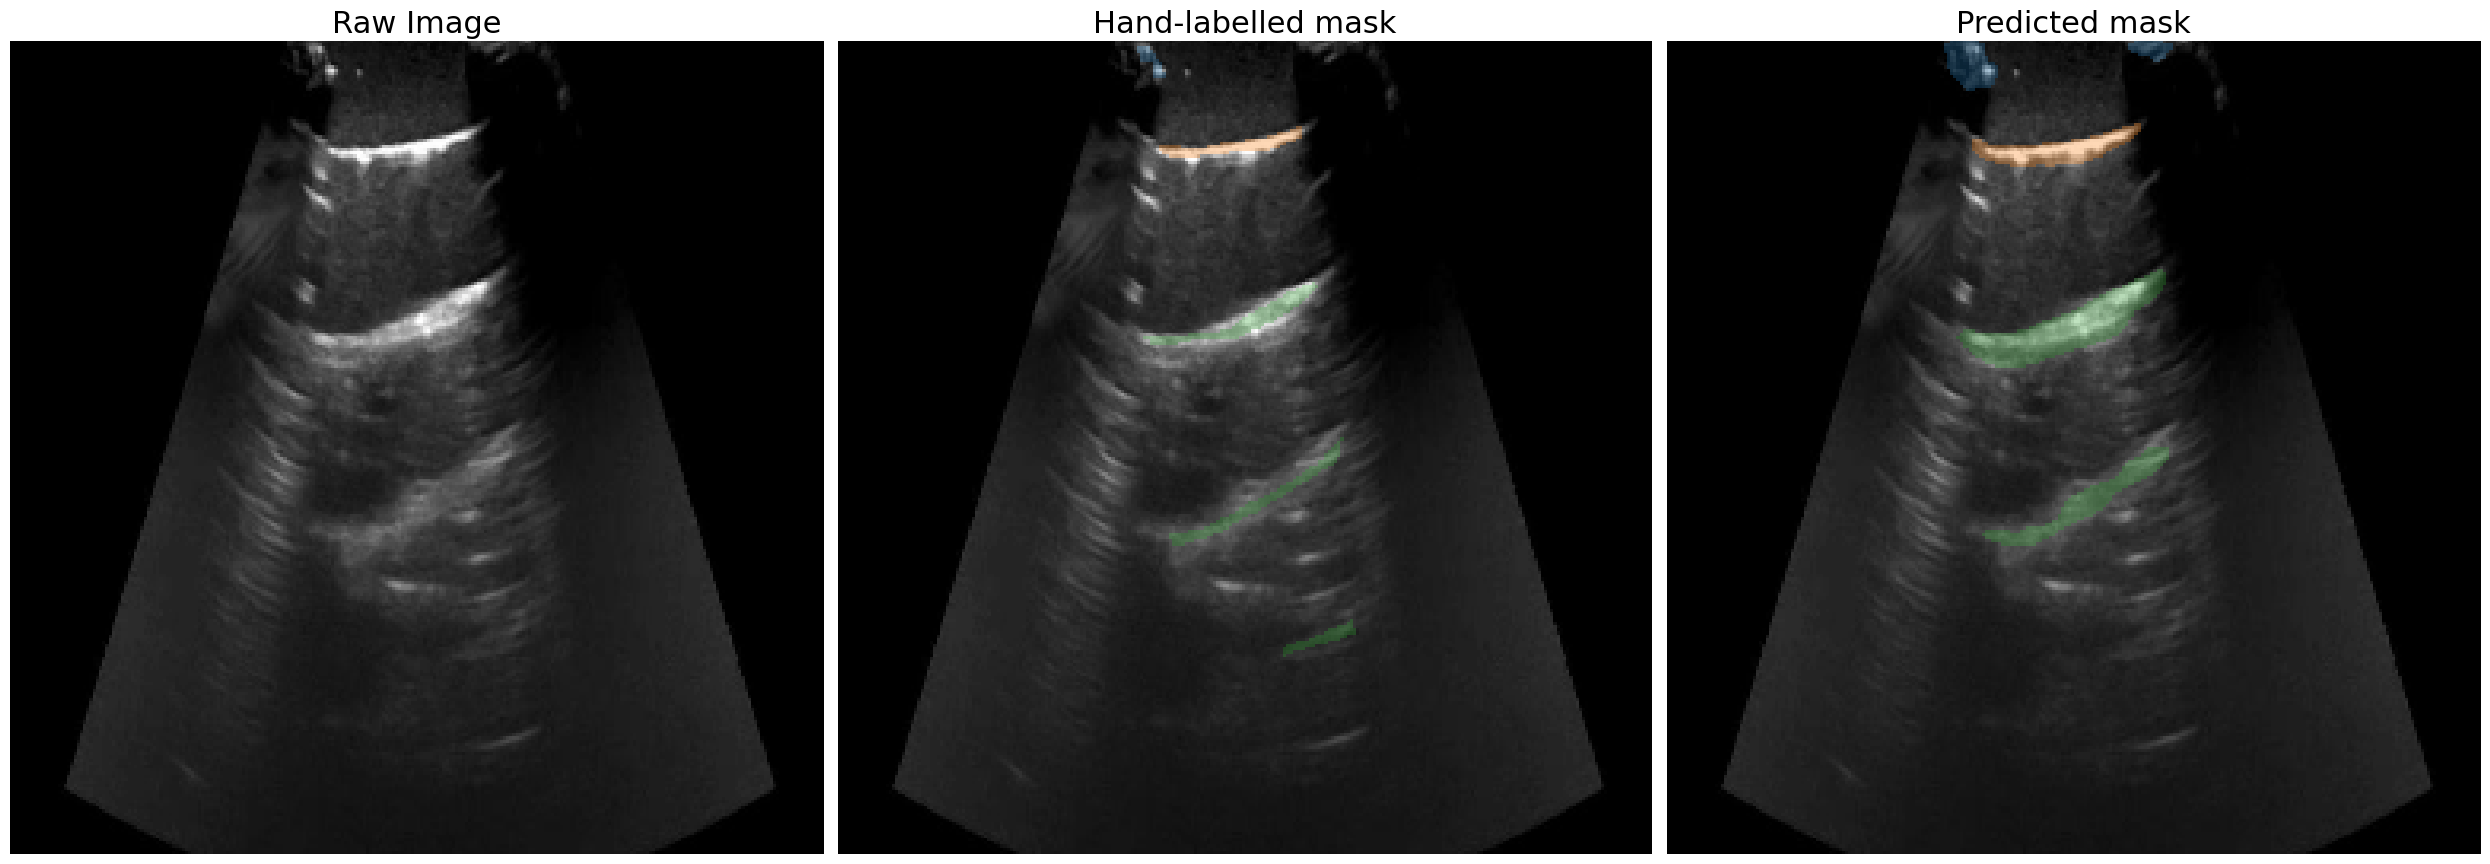

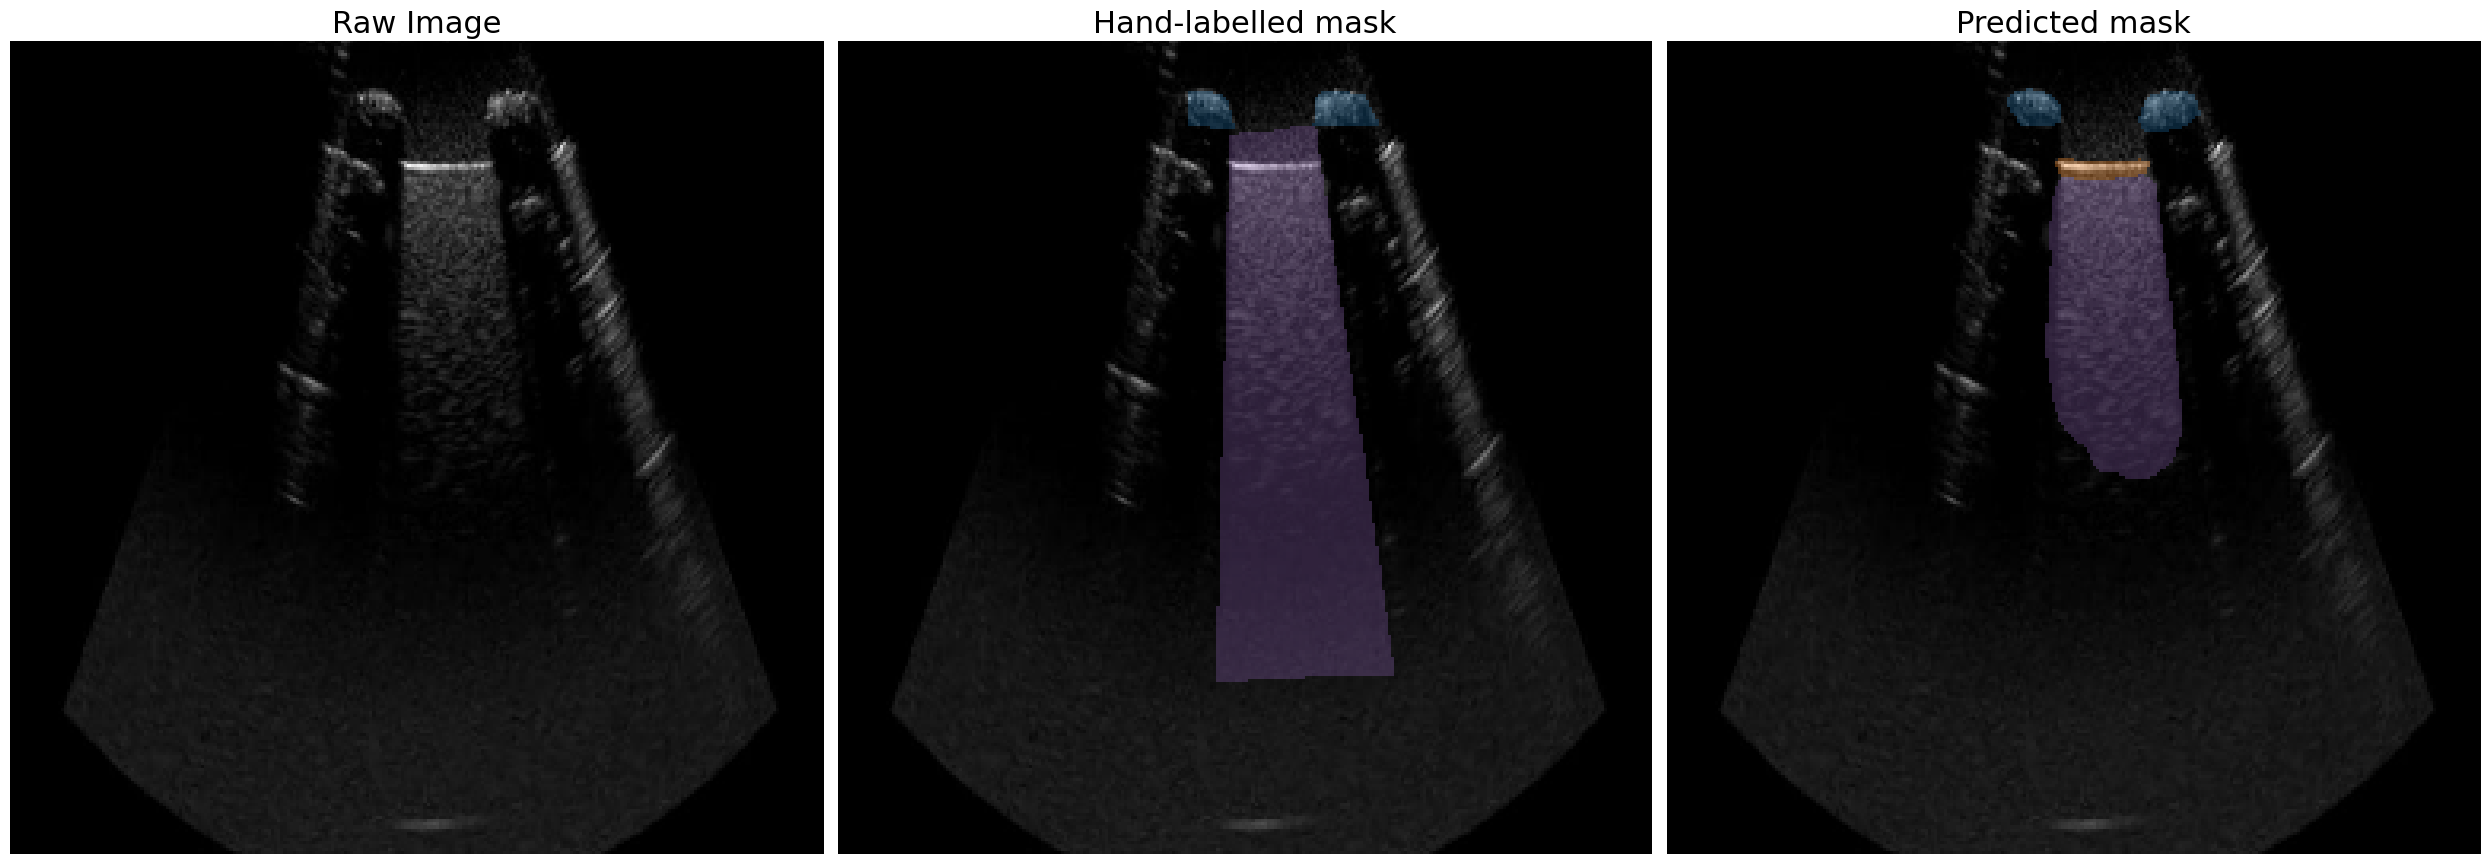

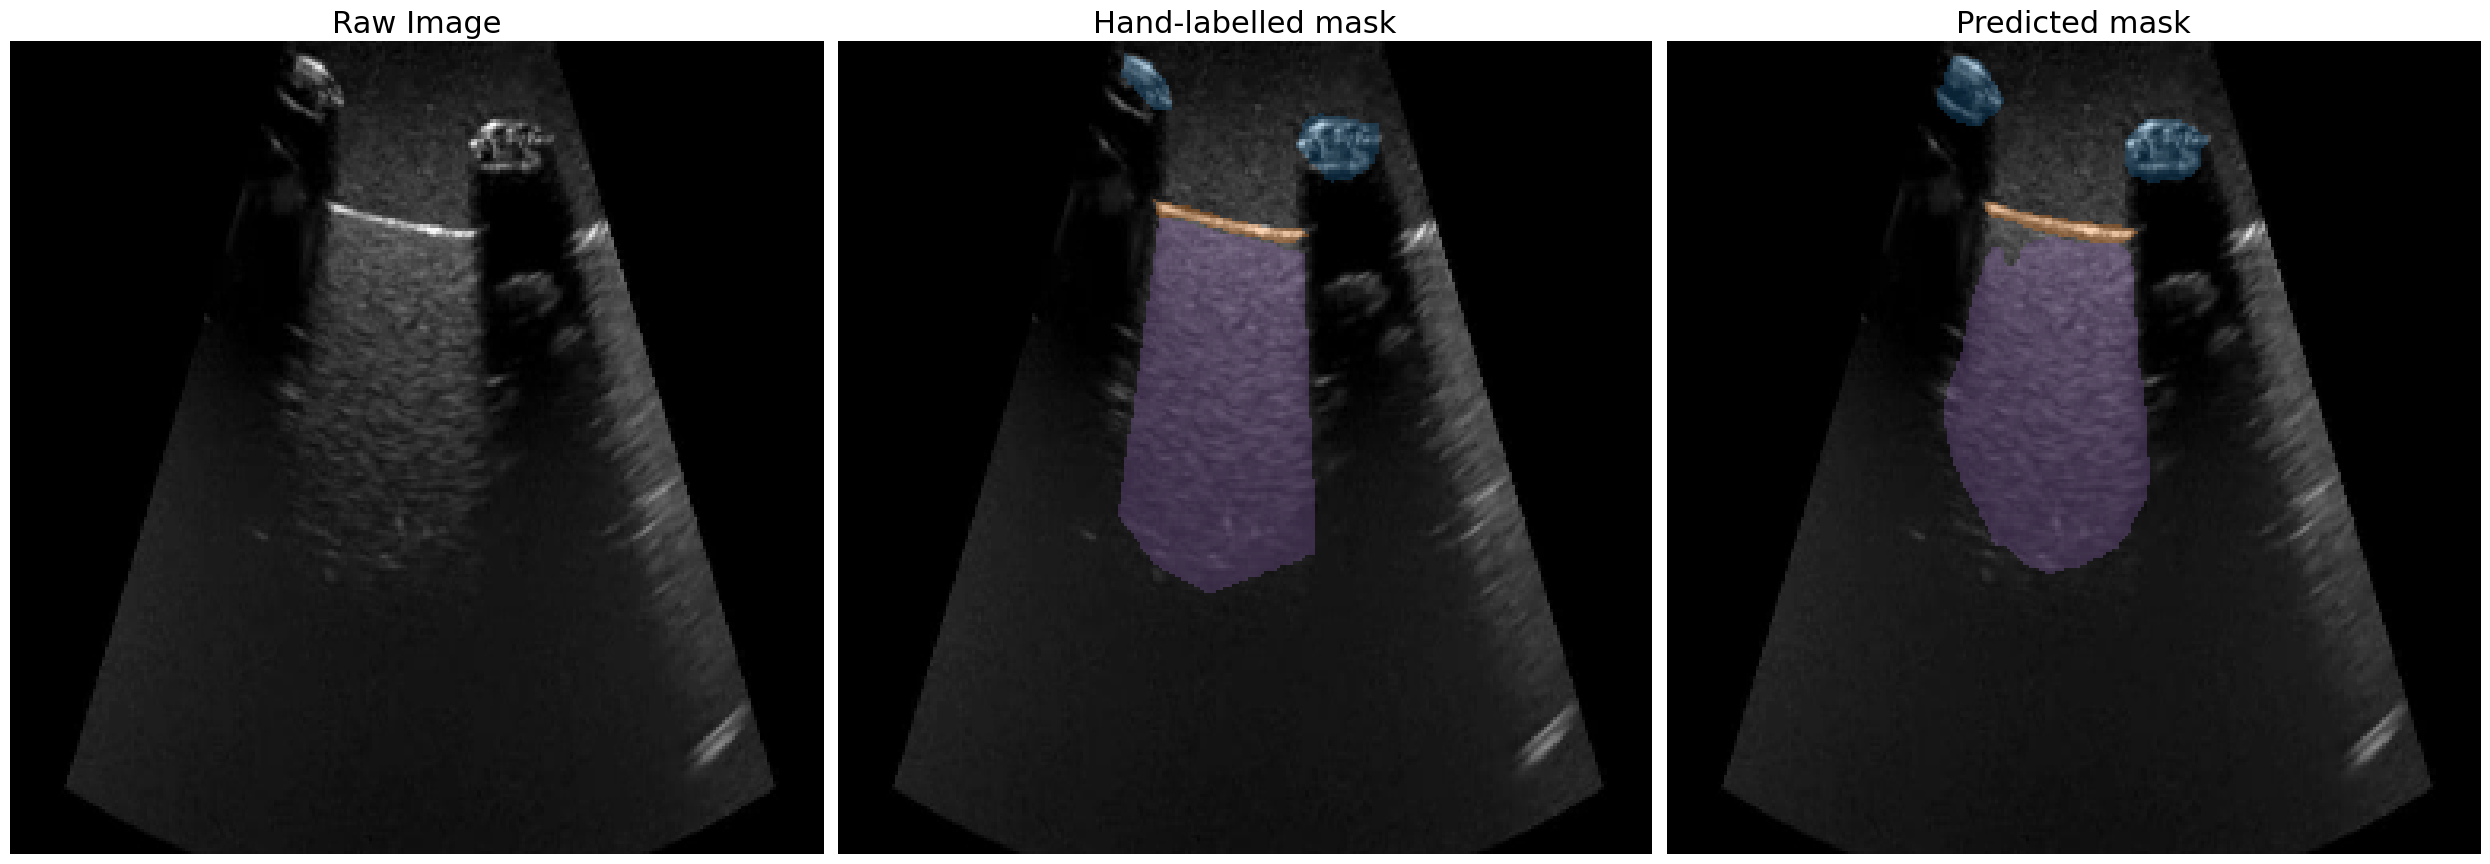

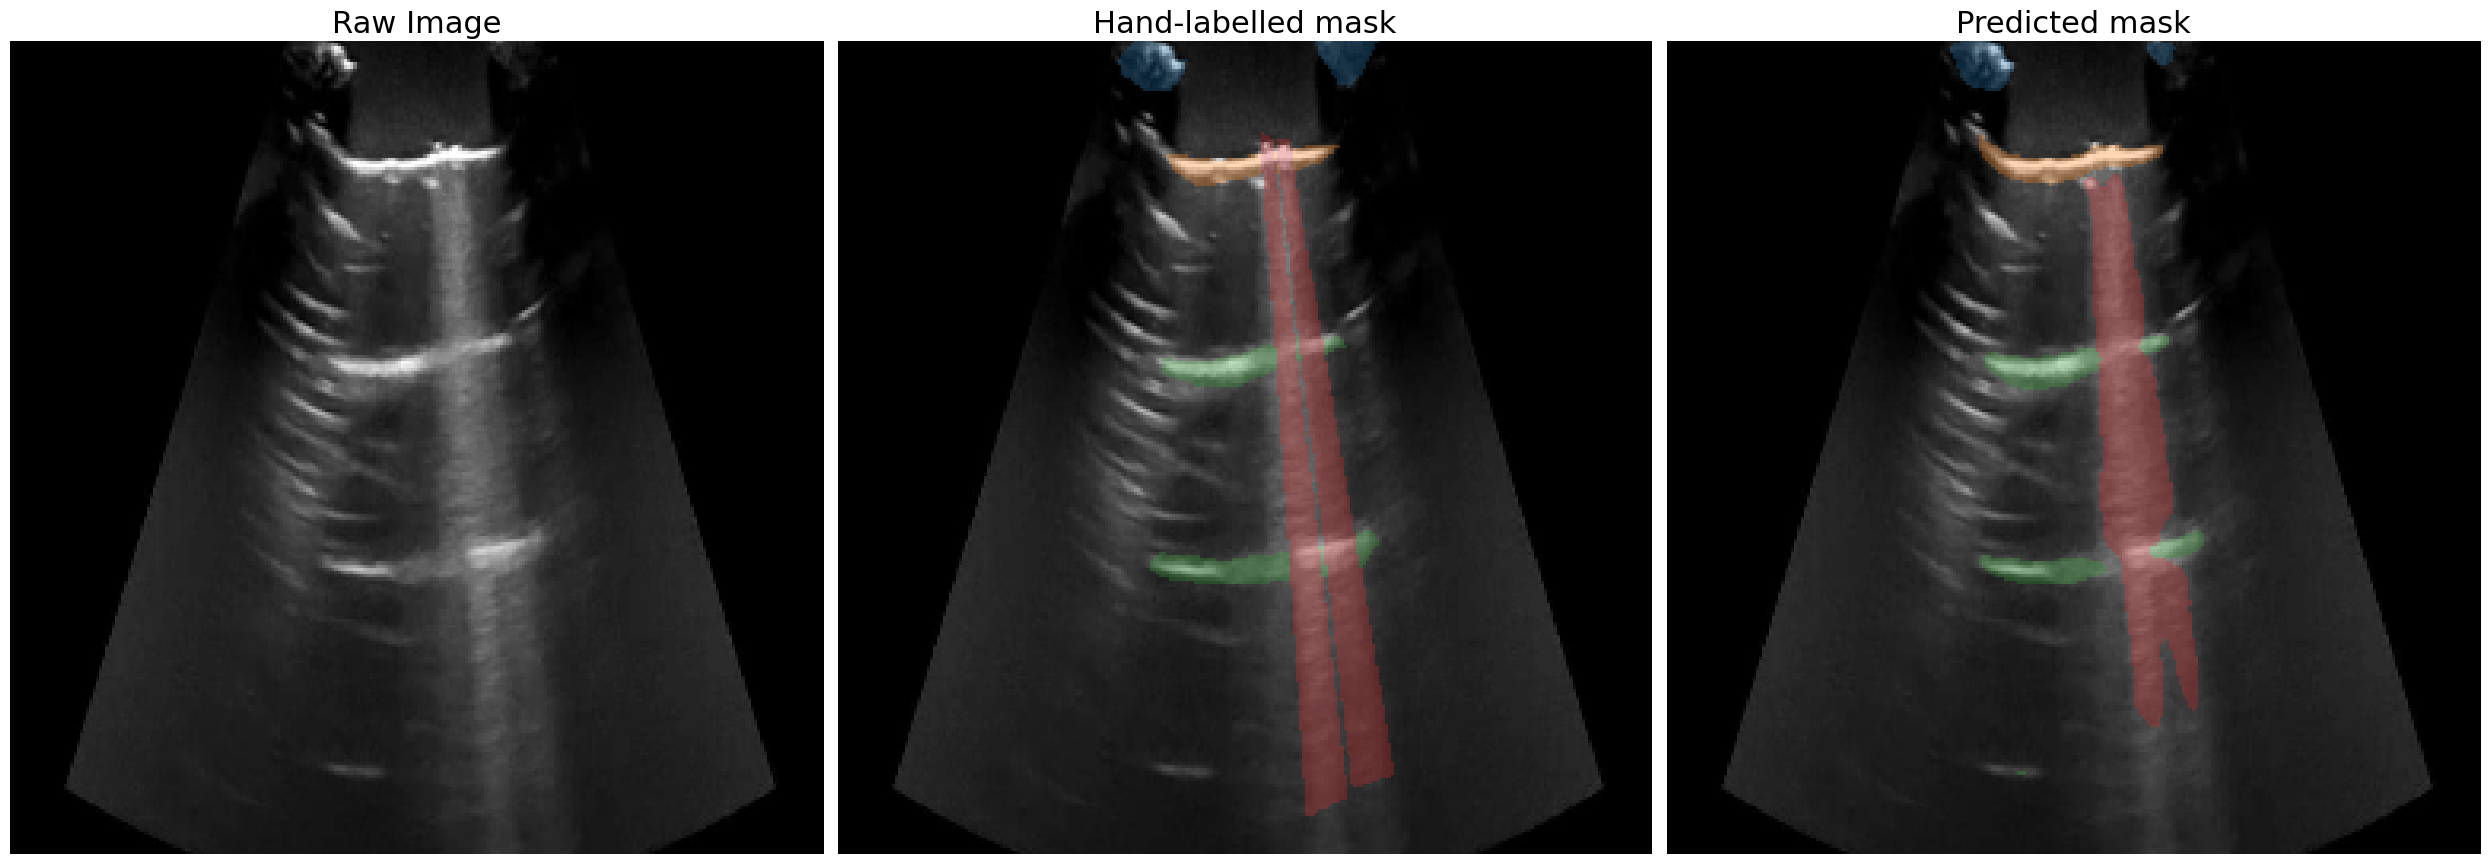

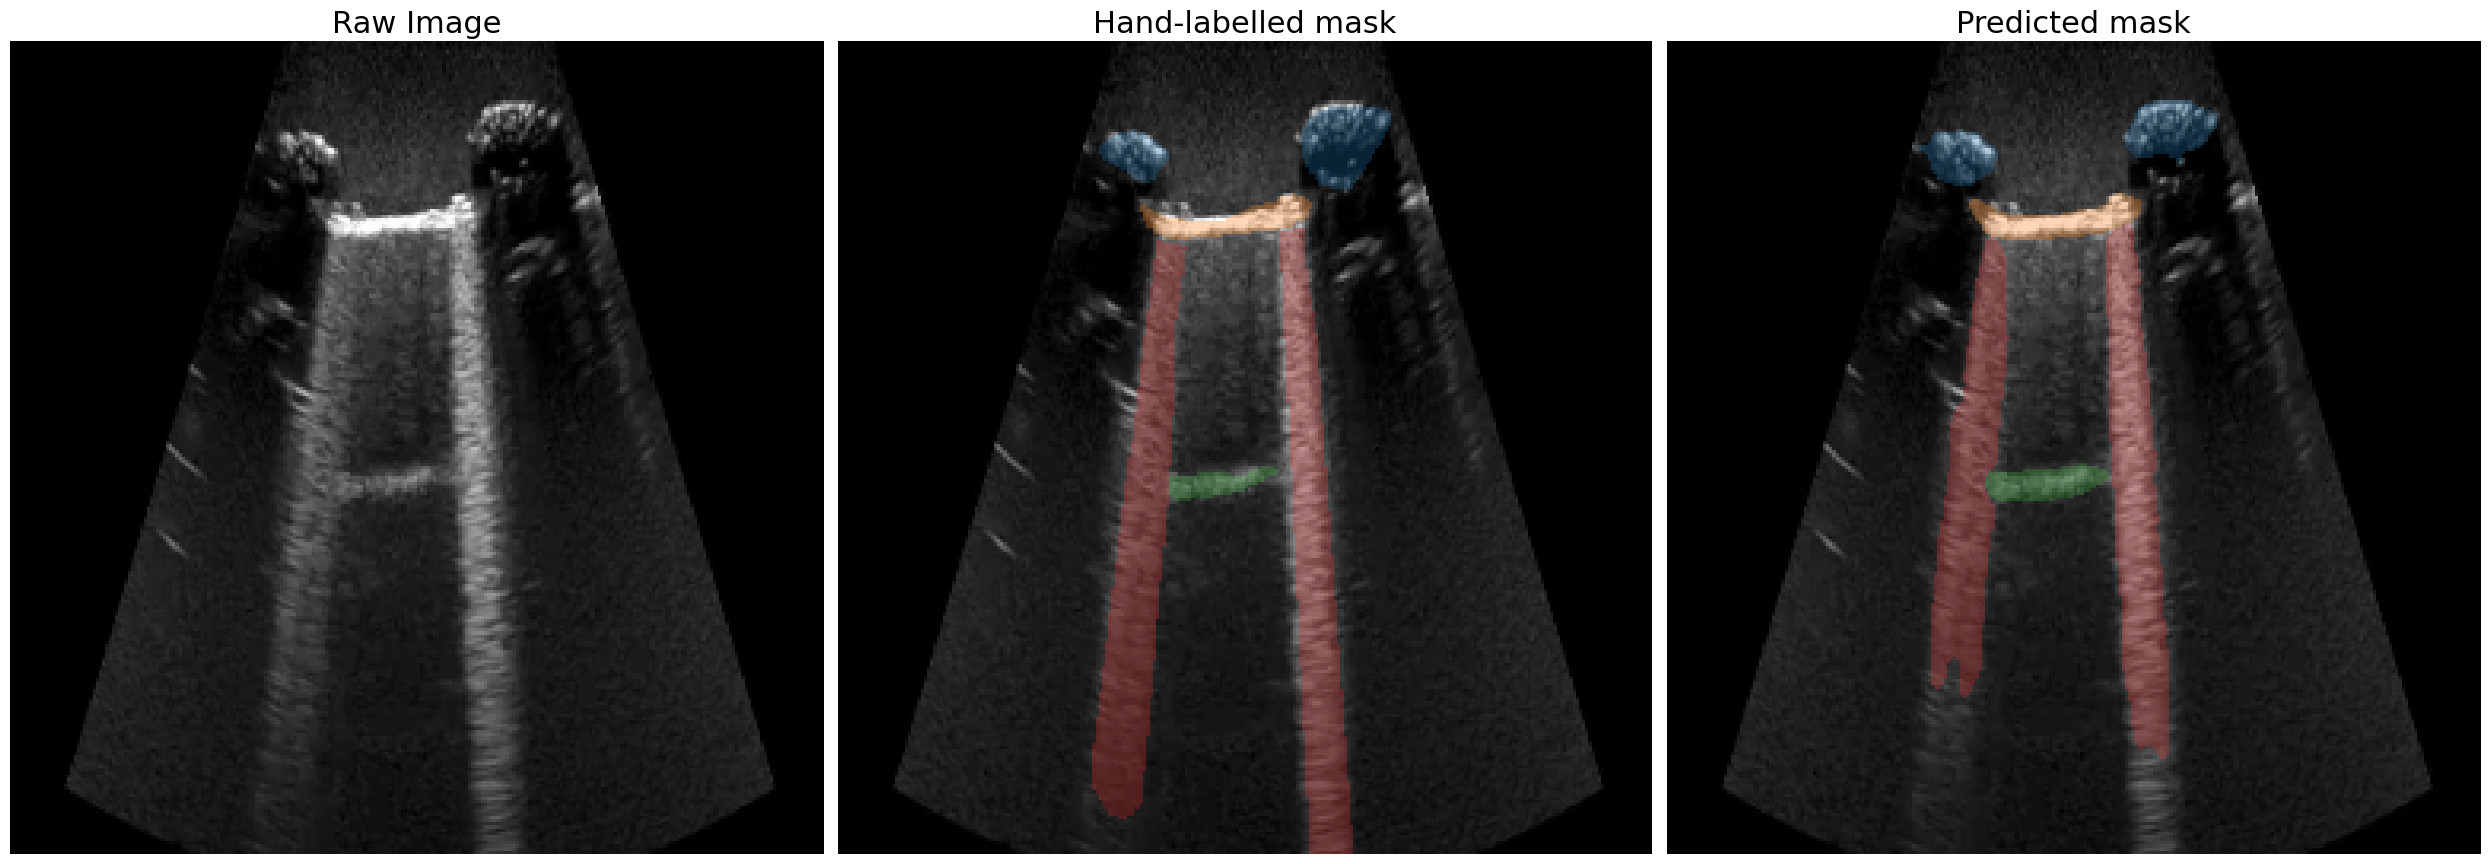

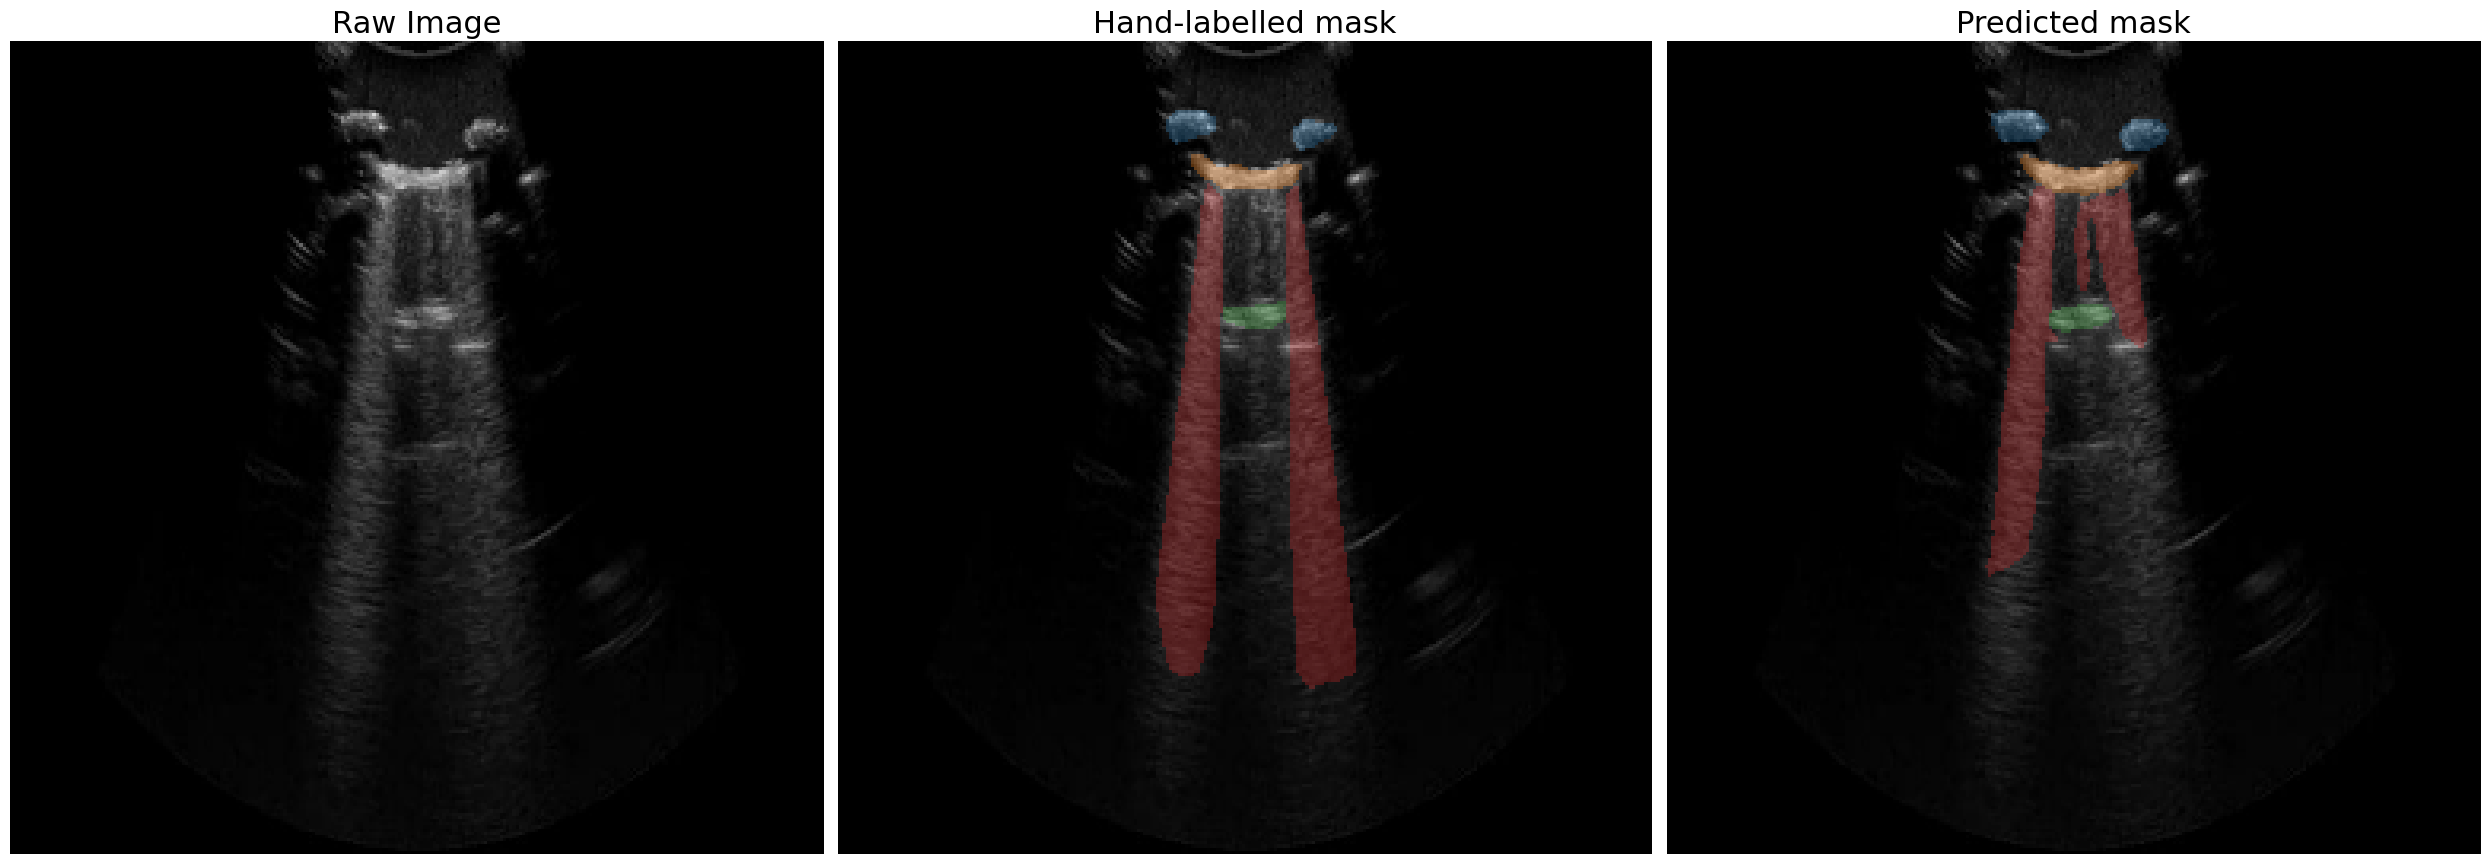

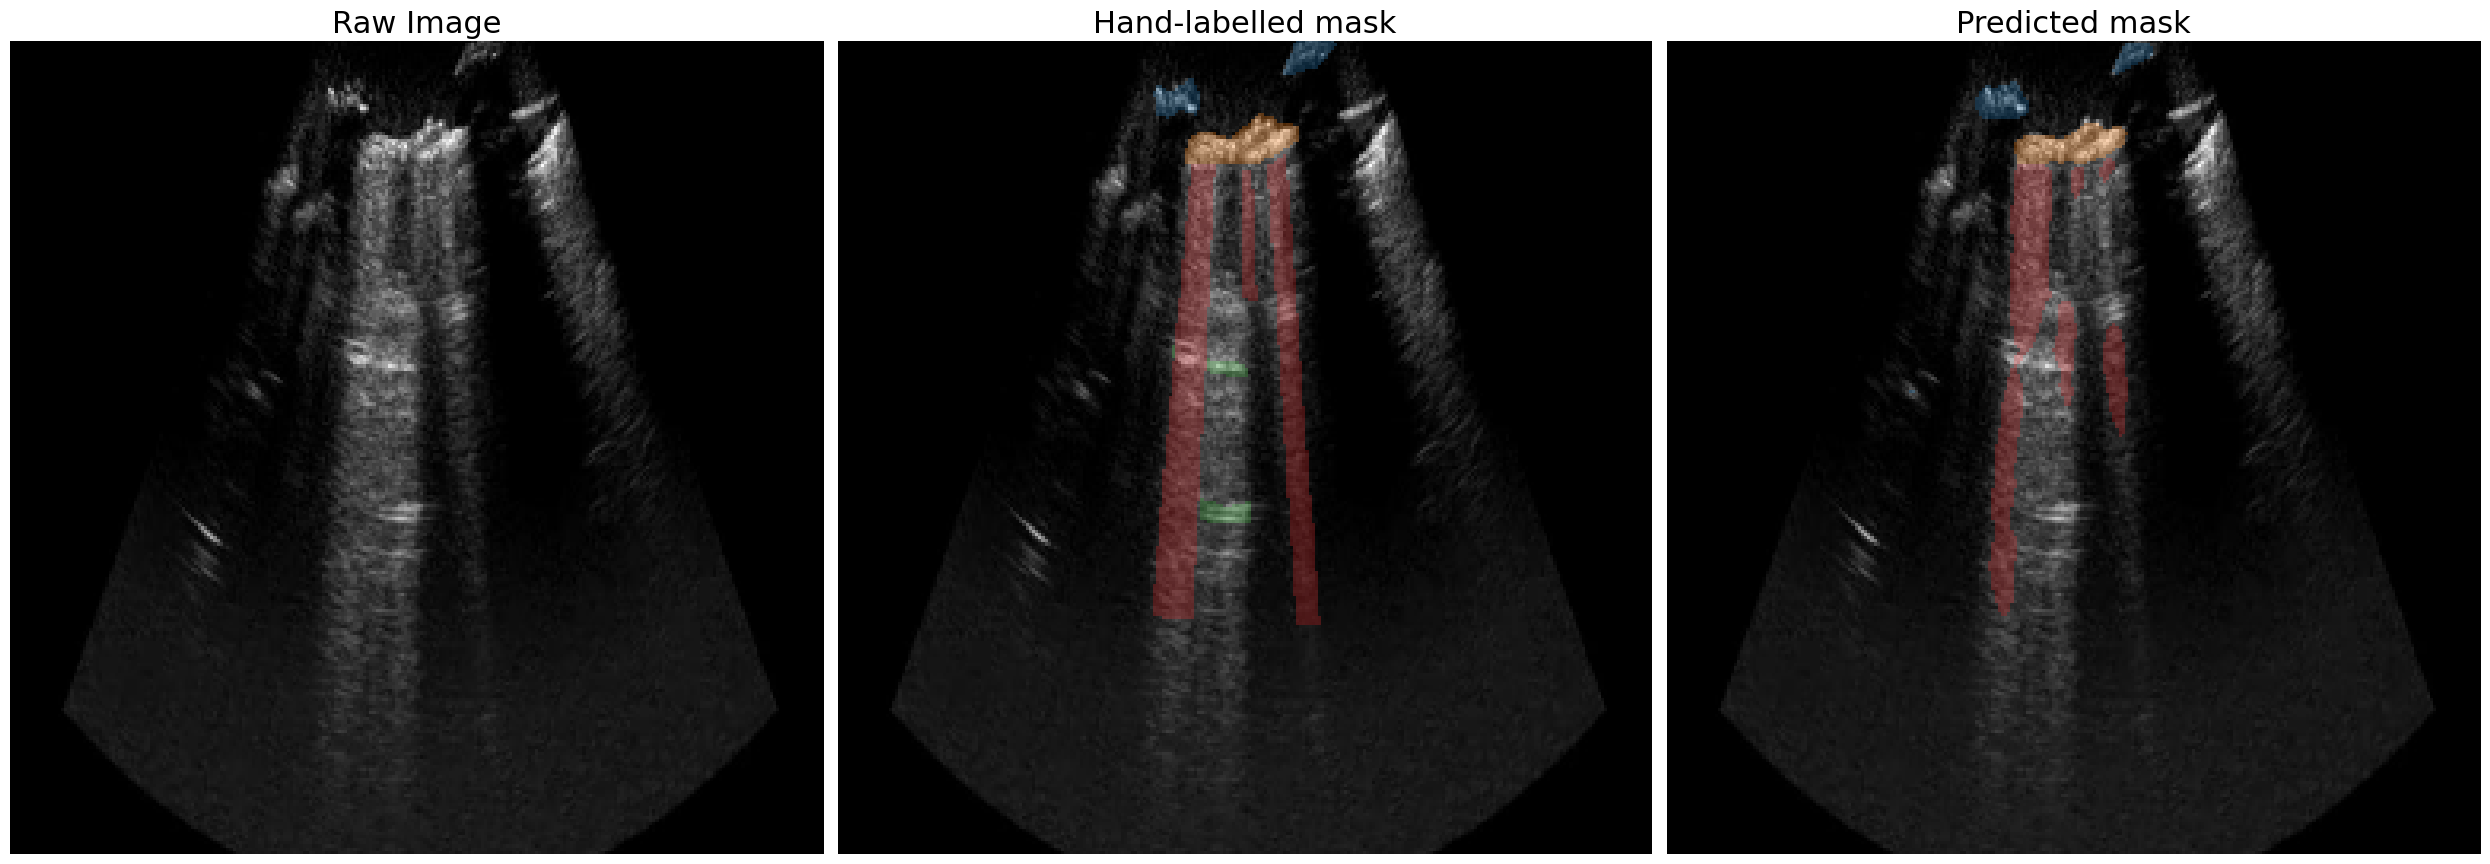

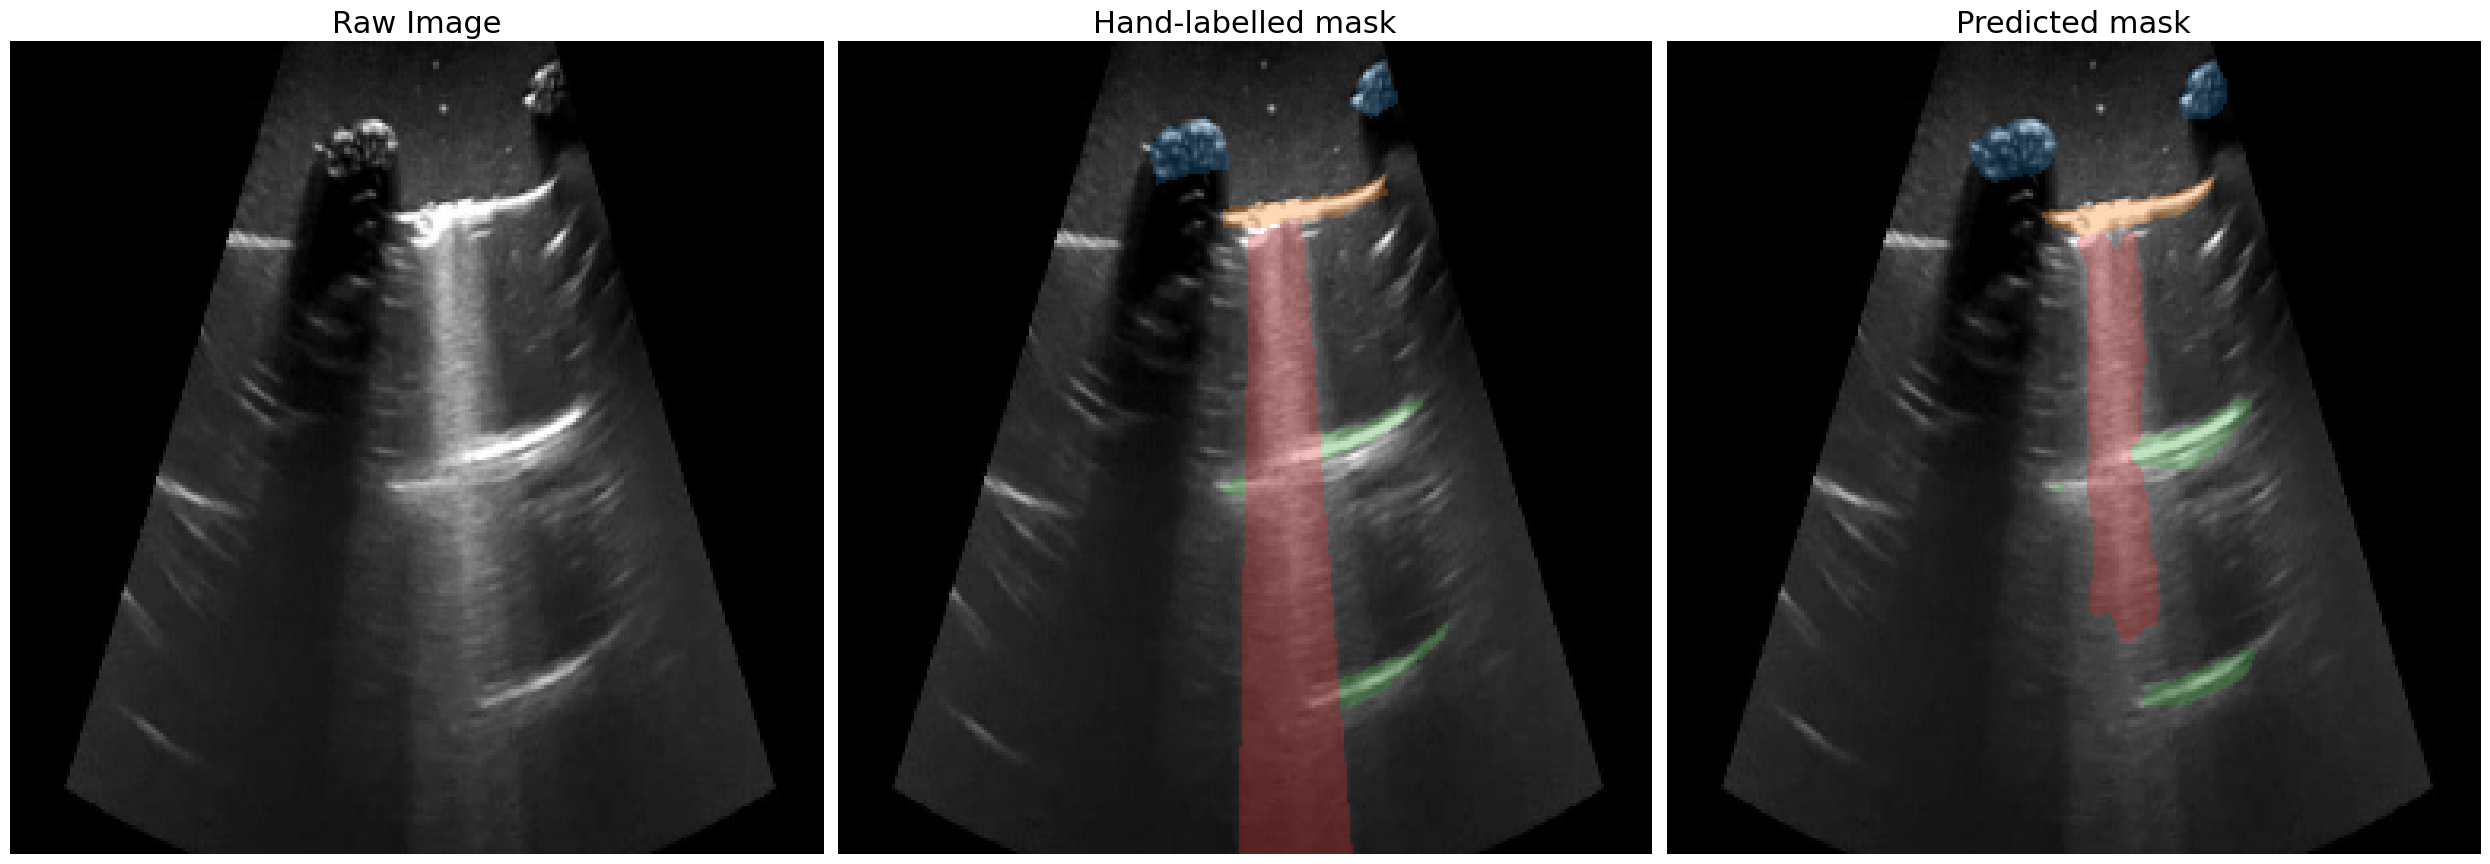

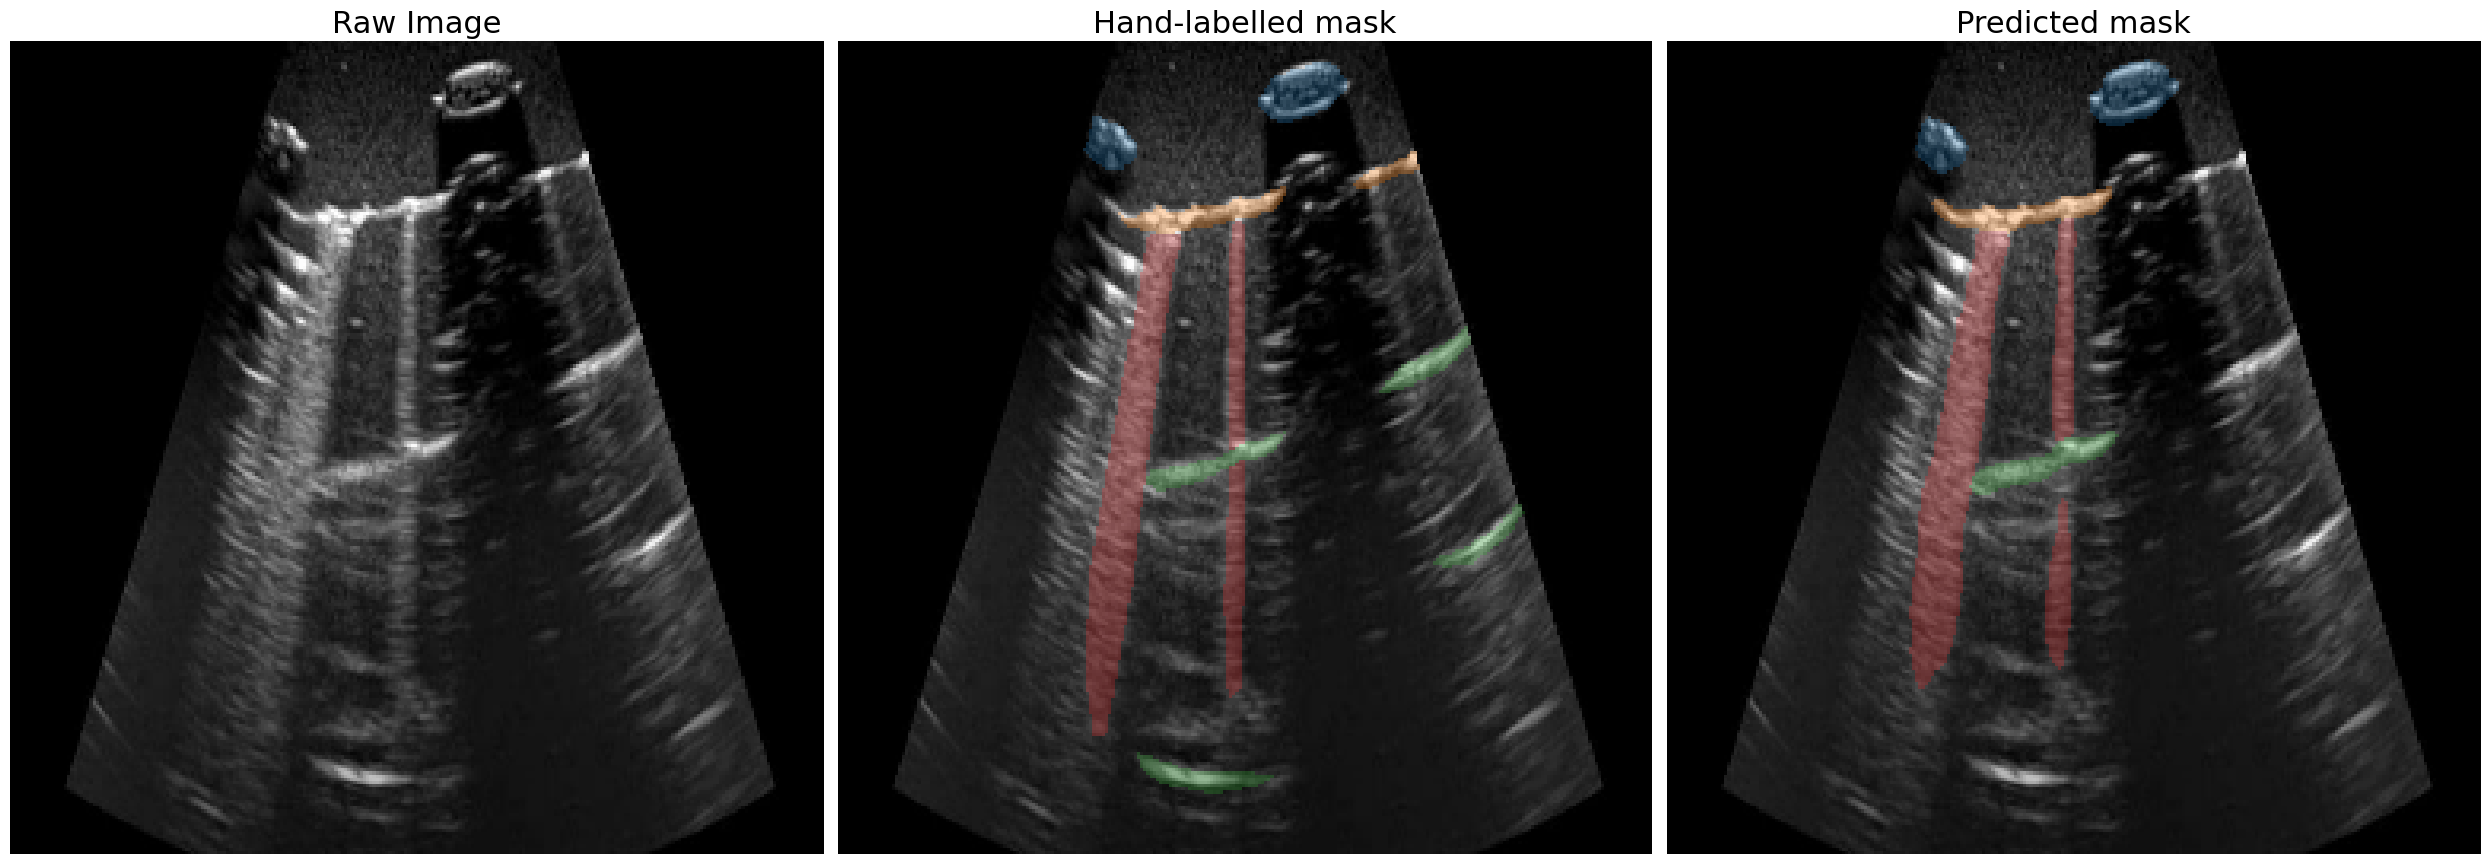

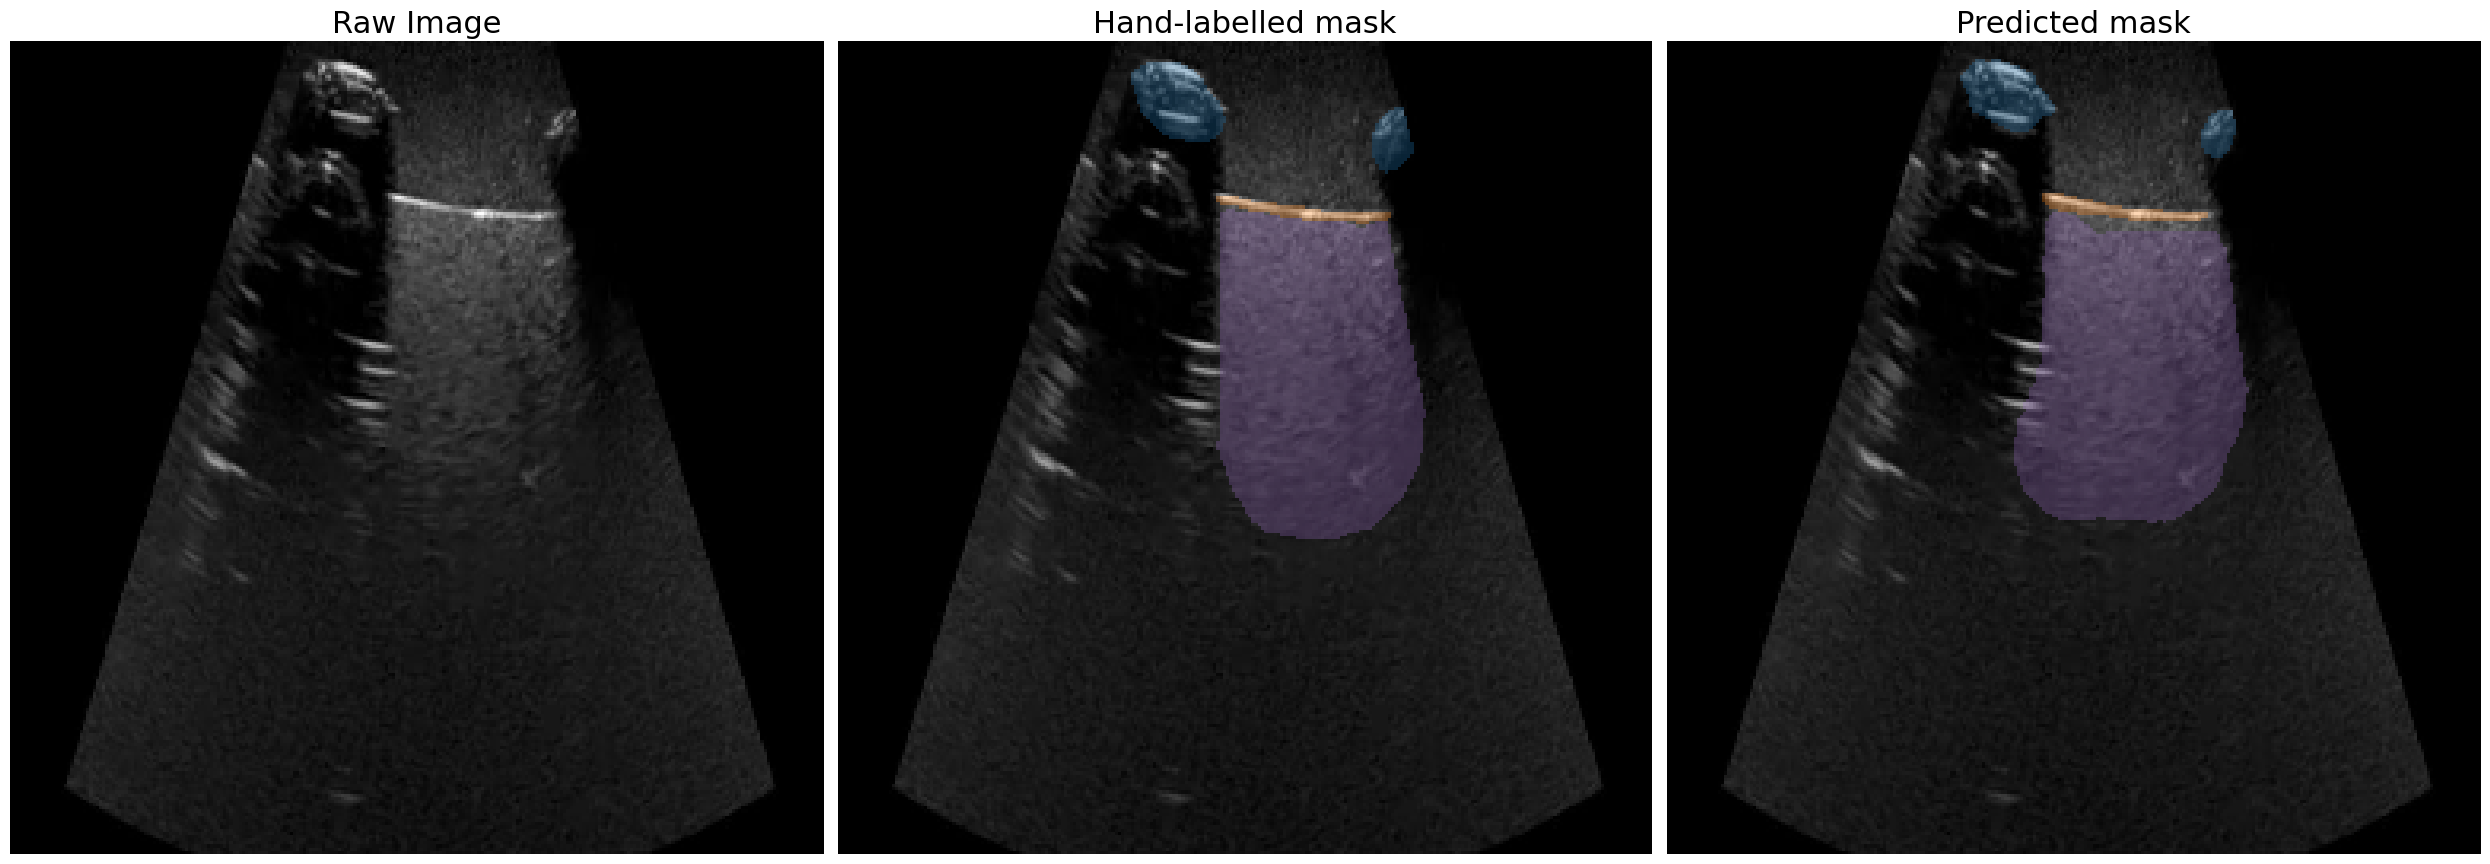

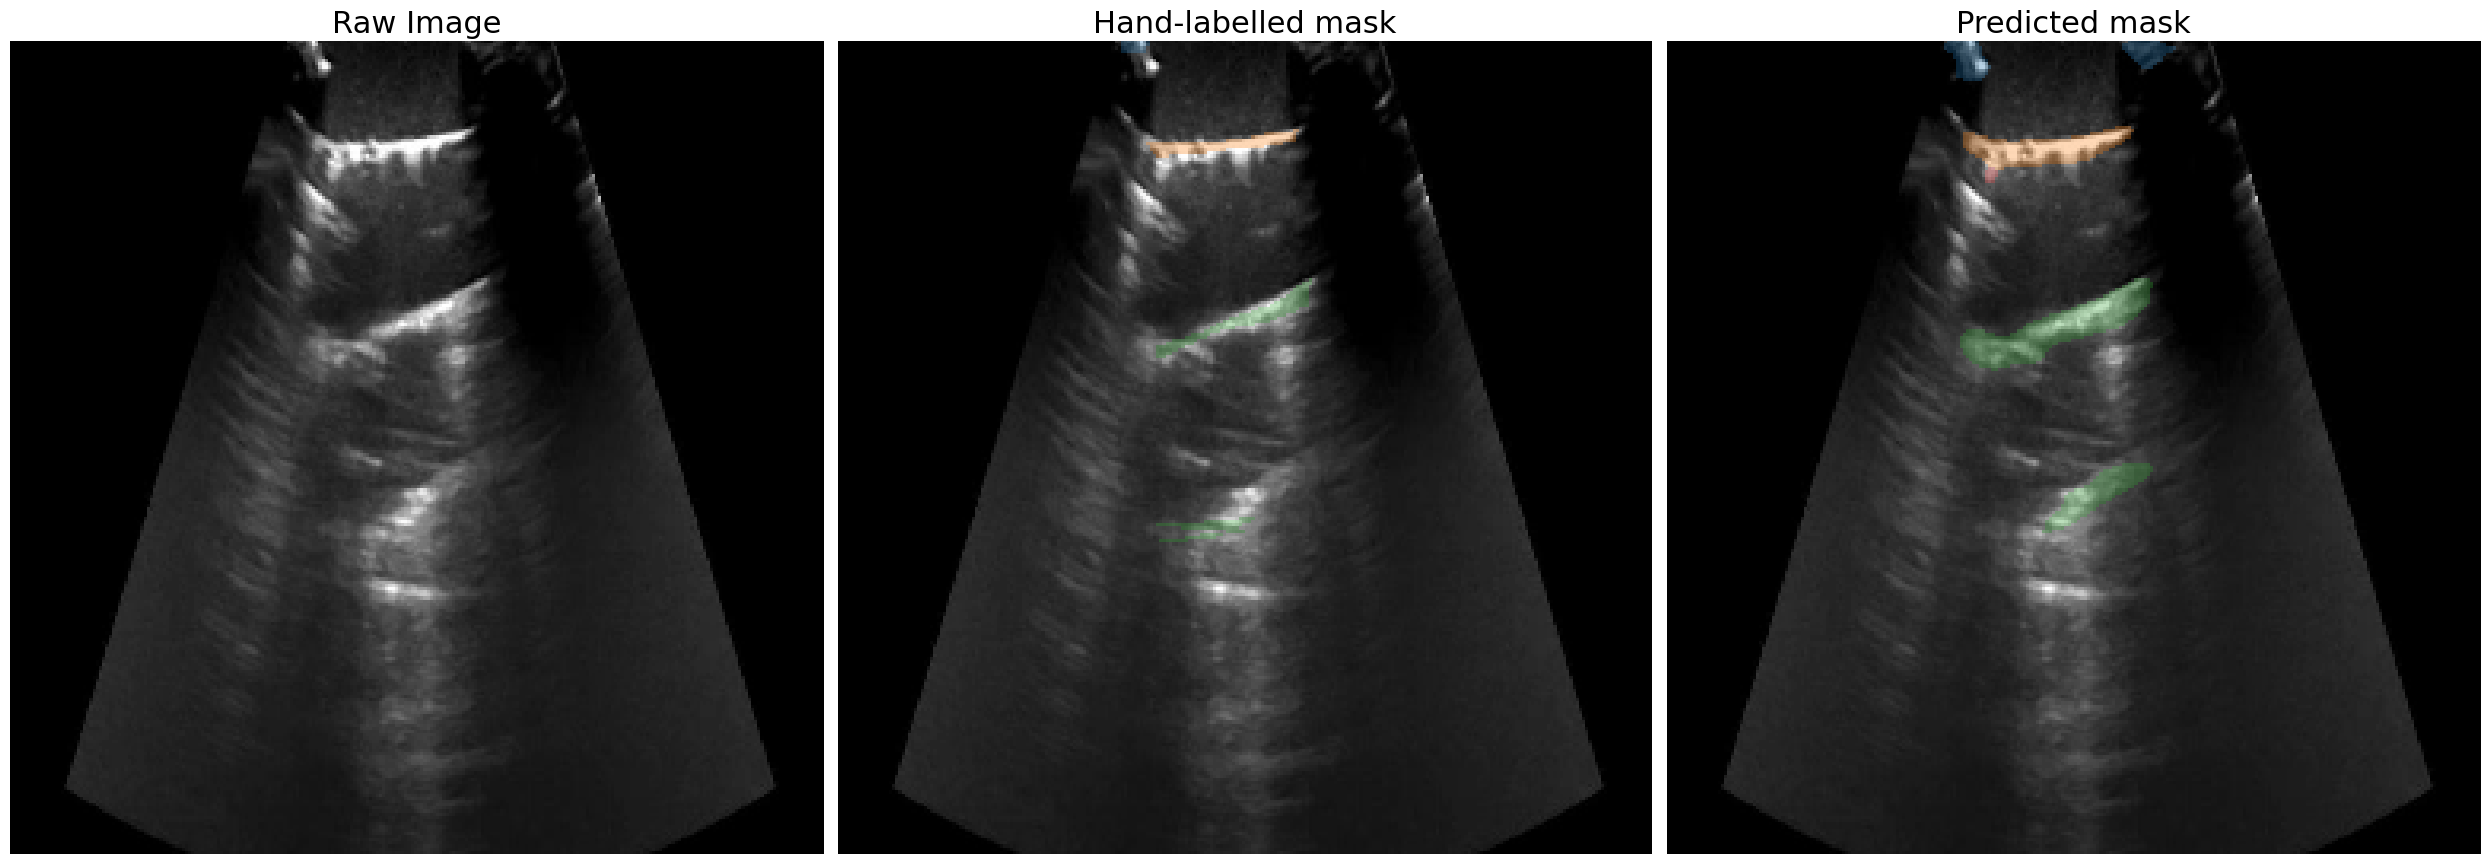

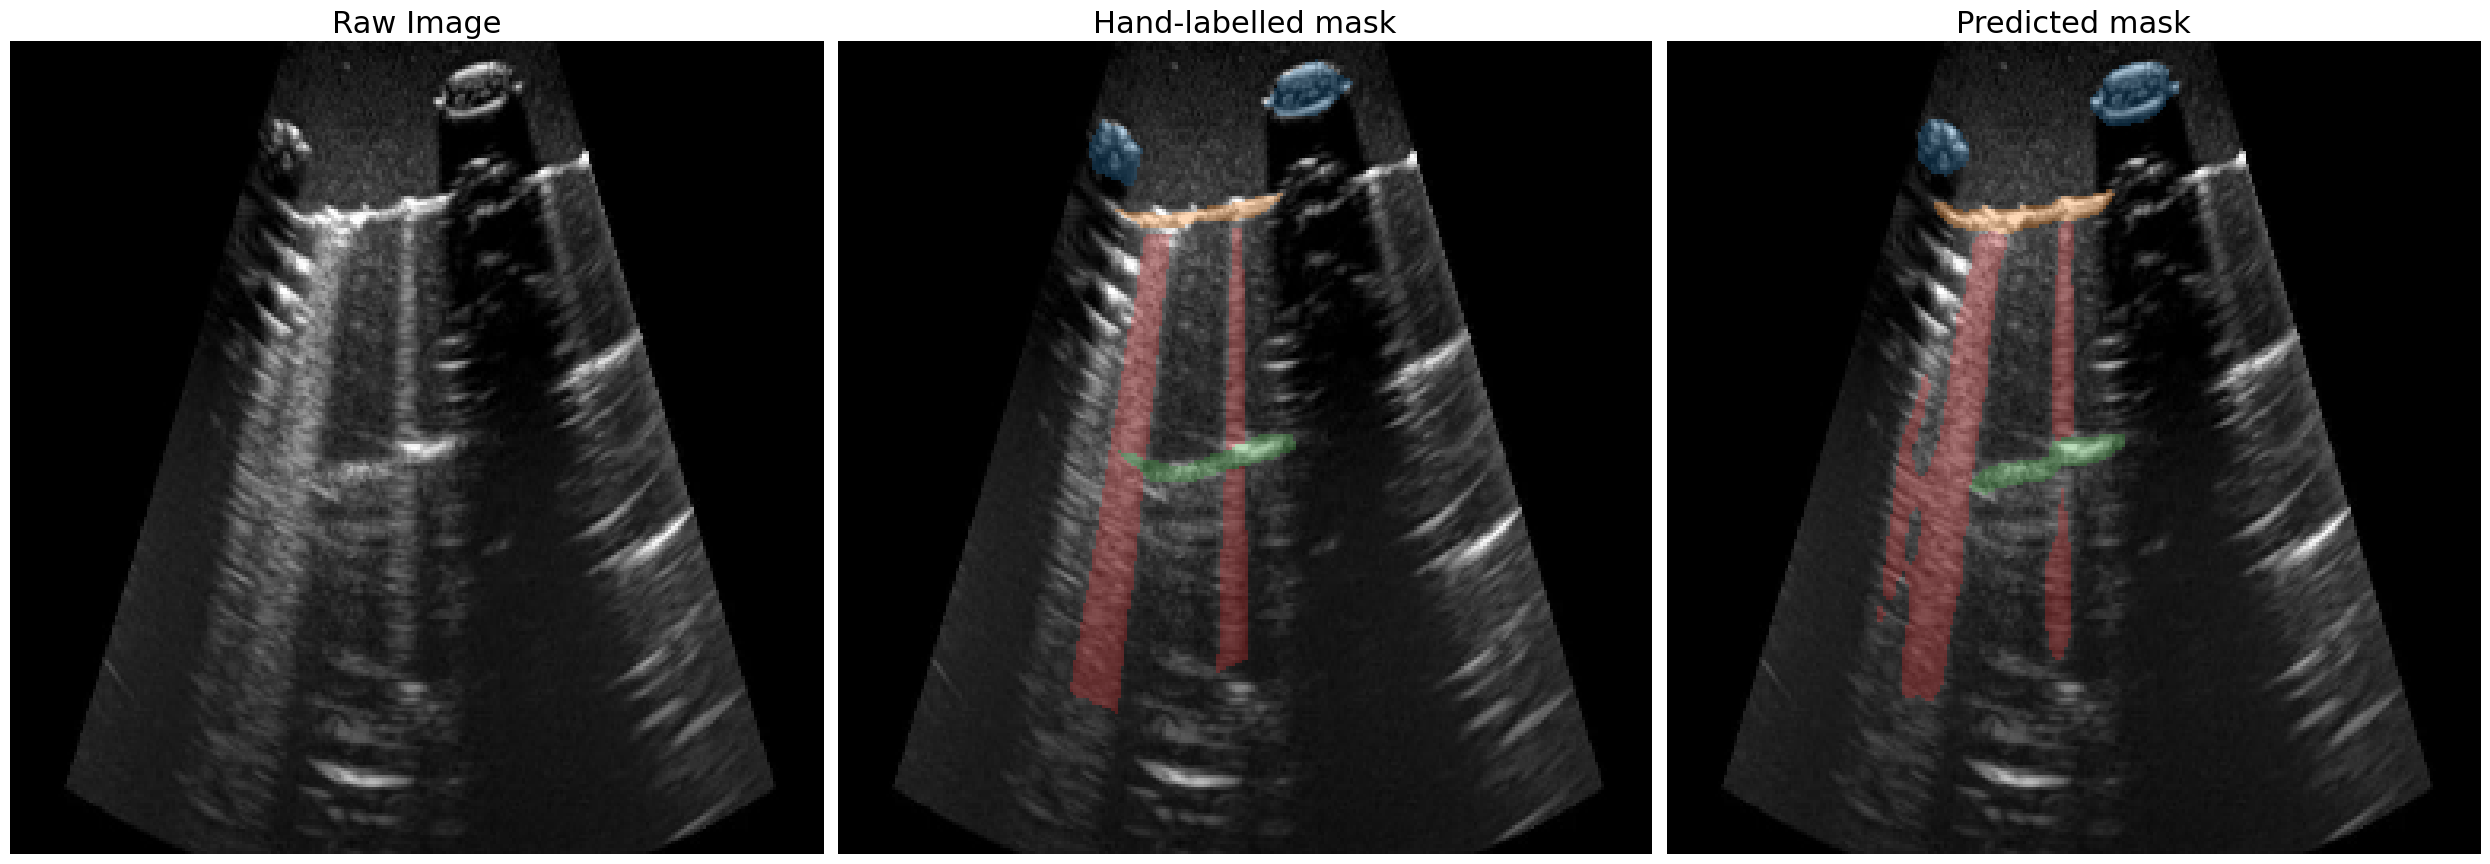

In [46]:
# Show pairs of ground truth and predicted masks
n_display = 25

for i, m in enumerate(test_masks):
   
   if i == n_display or i == len(test_masks):
      break
    
   # Get image, predicted mask, ground truth mask
   im = images[i]
   mask_pred = np.argmax(m, axis=2) # one-hot decode mask
   gt_mask = np.argmax(gt_masks[i], axis=2) # one-hot decode mask
   
   # Plotting  
   fig, axs = plt.subplots(1,3, figsize=(25,10))
   vis.display_image_mask(im, mask=None, axs=axs[0], alpha=0.3,d_classes=d_classes, 
                           legend_loc=None,
                           title='Raw Image', 
                           # save='./outputs/predictions/Image_{}_actual.png'.format(i)
   )
   vis.display_image_mask(im, gt_mask, axs=axs[1], alpha=0.3,d_classes=d_classes, 
                           legend_loc=None,
                           title='Hand-labelled mask', 
                           # save='./outputs/predictions/Image_{}_actual.png'.format(i))
   )
   vis.display_image_mask(im, mask_pred, axs=axs[2], alpha=0.3,d_classes=d_classes, 
                           legend_loc=None,
                           title='Predicted mask',
                           # save='./outputs/predictions/Image_{}_pred.png'.format(i)
   )
    
   fig.tight_layout()
   # plt.savefig('./outputs/predictions/Image_{}_pred.pdf'.format(i), dpi=300)

# Calculate the B-line artefact score (BLAS)
The B-line artefact score is an example of a semi-quantitative metric used to assess the amount of the intercostal space (between the ribs) that is occupied by B-lines or confluent B-lines and is calculated using the segmentation masks.
1. Extract the region of interest (ROI), defined by the boarders of the pleural line and extending to the lowest extent of the detected B-lines.
2. Plot the percentage of the ROI that is occupied by B-lines or confluent B-lines with depth and calculate the BLAS (average percentage of the ROI occupied by B-lines or confluent B-lines with depth).
Empirically, larger values of the BLAS indicate more B-lines which may suggest greater degree of lung aeration loss. 

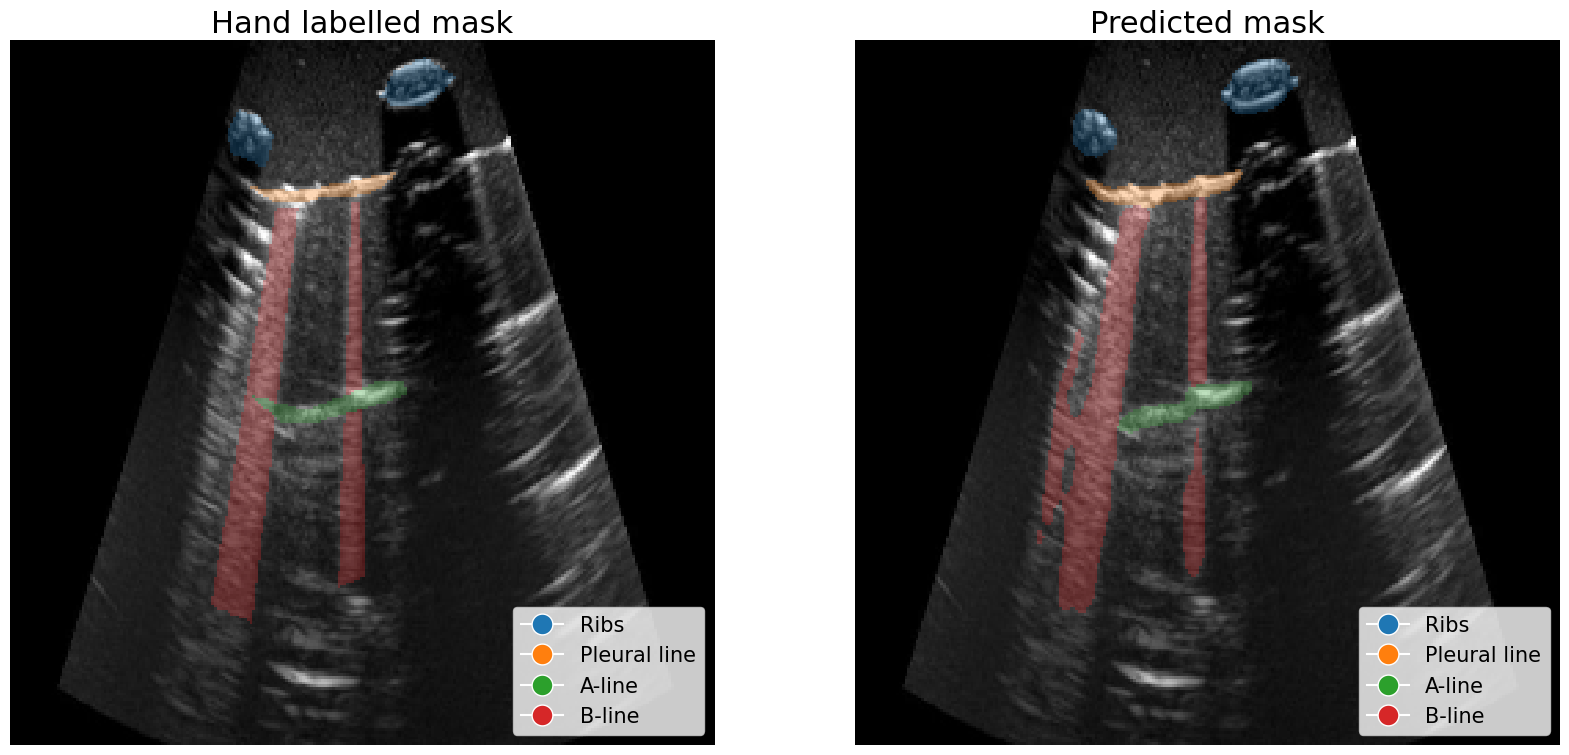

In [47]:
# Display an example image
fig, axs = plt.subplots(1,2, figsize=(20,10))
vis.display_image_mask(im, gt_mask, axs=axs[0], alpha=0.3,d_classes=d_classes, legend_loc='lower right',
                           title='Hand labelled mask')
vis.display_image_mask(im, mask_pred, axs=axs[1], alpha=0.3,d_classes=d_classes, legend_loc='lower right',
                        title='Predicted mask')

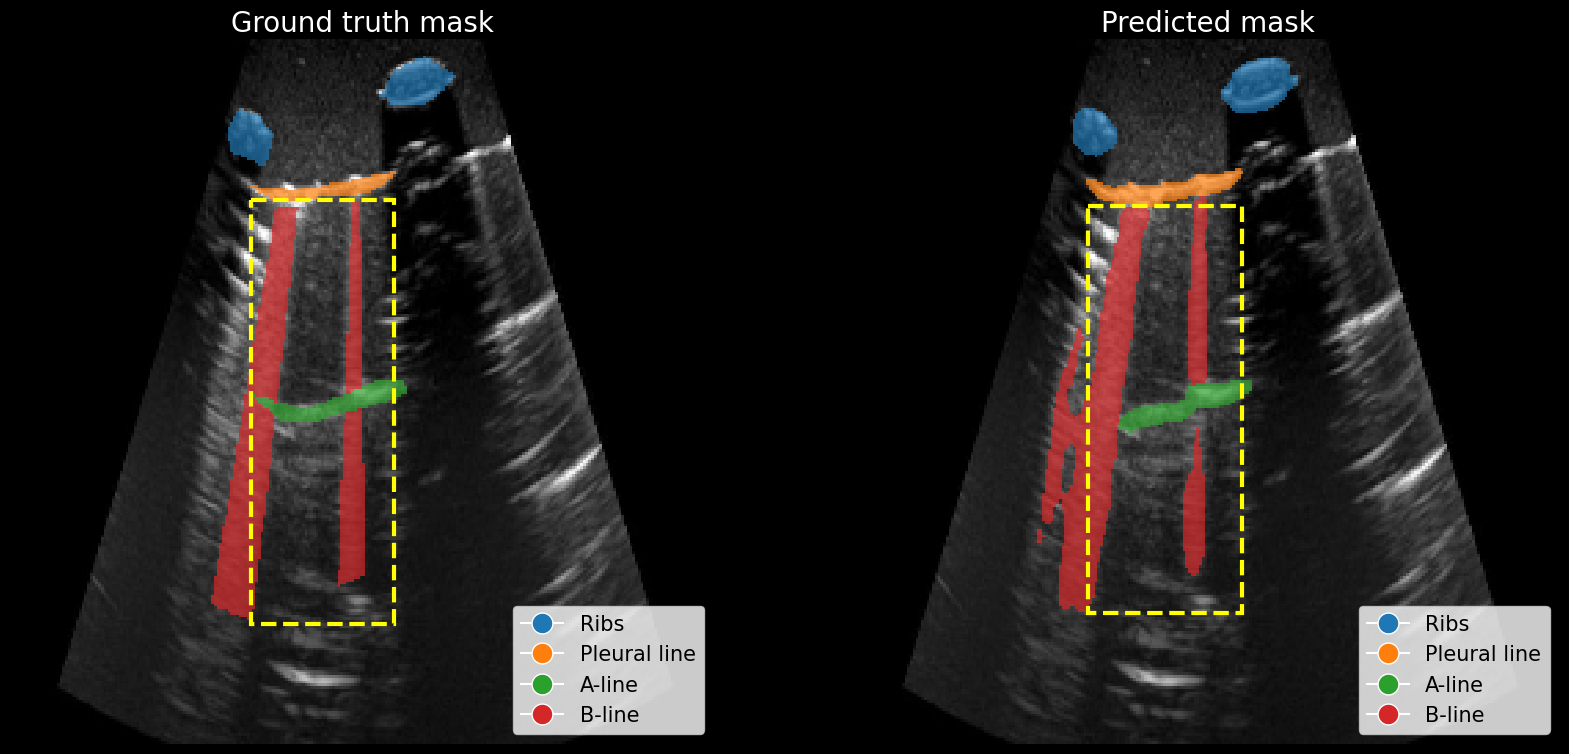

In [48]:
# 1. Extract the ROI
bbox_gt = blas.roi_bbox(gt_mask)
bbox_pred = blas.roi_bbox(mask_pred)


# Plot the ROI
fig, axs = plt.subplots(1,2, figsize=(20,10))
if bbox_gt is not None:
    axs[0].add_patch(Rectangle((bbox_gt[2],bbox_gt[0]),bbox_gt[3]-bbox_gt[2],bbox_gt[1]-bbox_gt[0],
                               linewidth=3,linestyle='--',edgecolor='yellow',facecolor='none'))
vis.display_image_mask(image=im, mask=gt_mask, axs=axs[0], alpha=0.7, d_classes=d_classes, legend_loc='lower right',
                        title='GT')
axs[0].set_title('Ground truth mask', fontsize=20, color='white')


if bbox_pred is not None:
    axs[1].add_patch(Rectangle((bbox_pred[2],bbox_pred[0]),bbox_pred[3]-bbox_pred[2],bbox_pred[1]-bbox_pred[0],
                               linewidth=3,linestyle='--',edgecolor='yellow',facecolor='none'))
vis.display_image_mask(image=im, mask=mask_pred, axs=axs[1], alpha=0.7, d_classes=d_classes, legend_loc='lower right')
axs[1].set_title('Predicted mask', fontsize=20, color='white')

fig.set_facecolor("black")
plt.show()


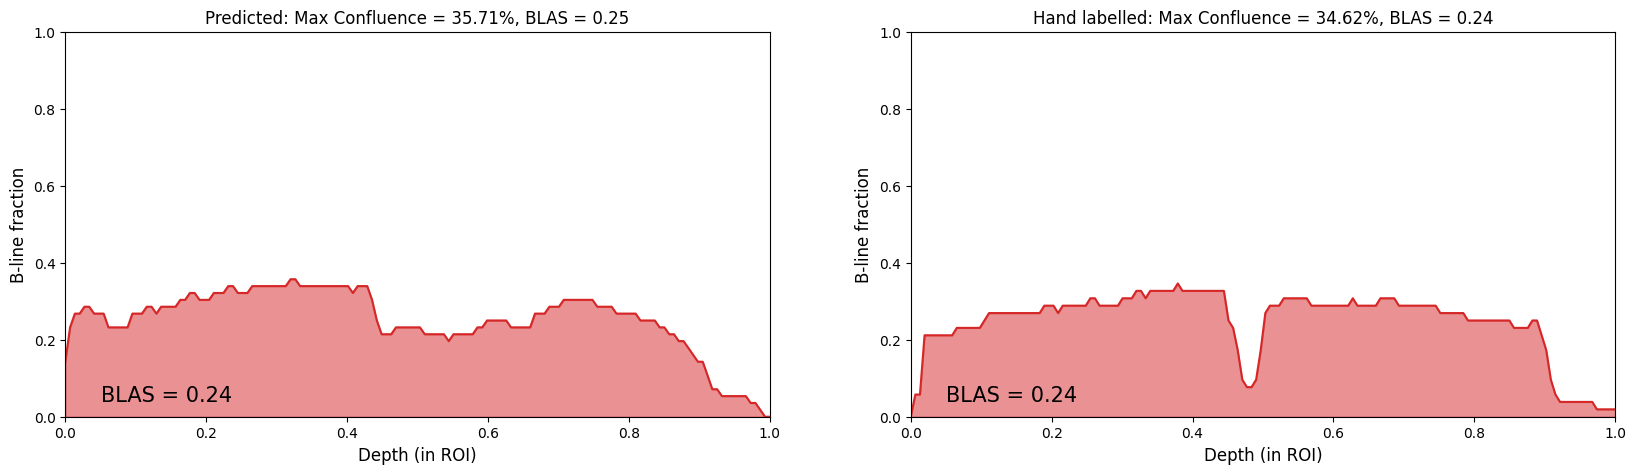

In [50]:
# 2. Plot the B-line percentage vs depth and calculate BLAS
blas_score_gt = blas.calc_blas(gt_mask)
blas_score_pred = blas.calc_blas(mask_pred)

# Plot the B-line percentage vs depth
fig, ax = plt.subplots(1,2, figsize=(20,5))
roi = blas.get_roi(mask_pred)
if roi is not None:
    roi_consolidaion = blas.bline_fraction(roi)
    max_consolidaion = max(roi_consolidaion)
    
    x = np.linspace(0,1,len(roi_consolidaion))
    ax[0].plot(x, roi_consolidaion, color='tab:red')
    ax[0].set_title('Predicted: Max Confluence = {:.2f}%, BLAS = {:.2f}'.format(max_consolidaion*100, blas_score_pred))
    ax[0].fill_between(x, roi_consolidaion, alpha=0.5, color='tab:red')
    ax[0].text(0.05, 0.03, 'BLAS = {:.2f}'.format(blas_score), fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    ax[0].set_xlabel('Depth (in ROI)', fontsize=AXIS_FONT_SIZE)
    ax[0].set_ylabel('B-line fraction', fontsize=AXIS_FONT_SIZE)
    ax[0].set_xlim([0,1])
    ax[0].set_ylim([0,1])

roi = blas.get_roi(gt_mask)
if roi is not None:
    roi_consolidaion = blas.bline_fraction(roi)
    max_consolidaion = max(roi_consolidaion)
    
    x = np.linspace(0,1,len(roi_consolidaion))
    ax[1].set_title('Hand labelled: Max Confluence = {:.2f}%, BLAS = {:.2f}'.format(max_consolidaion*100, blas_score_gt))
    ax[1].plot(x, roi_consolidaion, color='tab:red')
    ax[1].fill_between(x, roi_consolidaion, alpha=0.5, color='tab:red')
    ax[1].text(0.05, 0.03, 'BLAS = {:.2f}'.format(blas_score), fontsize=15, horizontalalignment='left', verticalalignment='bottom')
    ax[1].set_xlabel('Depth (in ROI)', fontsize=AXIS_FONT_SIZE)
    ax[1].set_ylabel('B-line fraction', fontsize=AXIS_FONT_SIZE)
    ax[1].set_xlim([0,1])
    ax[1].set_ylim([0,1])